In [1]:
# ipython magic functions for automatic reloading coda changes in .py files
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from encoder import Encoder
from decoder import Decoder
from model import ED
from net_params import convlstm_encoder_params, convlstm_decoder_params, convgru_encoder_params, convgru_decoder_params
import torch
import utils
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib
import pickle
import pandas as pd
import seaborn as sb
import cartopy.crs as ccrs
from data_loader import load_era5
plt.style.use('seaborn-deep')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Use device: ", device)

root = '../../../../../../mnt/data/scheepensd94dm/'
data_root = root + 'data/'
plot_root = root + 'data_visualization/'

class args():
    def __init__(self):
        self.frames_predict=12
        self.batch_size=16
        self.hpa=1000

args = args()

Use device:  cuda:0


In [11]:
"""
Random SEDI scores per threshold over all scales and cv splits. 
"""

t0 = np.array([
9.833966714043289e-06,
0.00012731778453528458,
-0.0006841476670302301,
-0.0014487732077952374,
-0.0015654216285019,
-0.0003509506581601943,
-0.0007242772109064497,
-2.6818255985634257e-05,
0.0010384351958239568,
2.1259530659183226e-05,
9.979869563236455e-05,
-0.00035299814746374226,
-0.0001645957393979788,
0.0015091326970814284,
0.0026556745680303153,
9.34483749523683e-05,
0.0008672265012850776,
0.0005480044109505265,
0.0007420334413131453,
0.00021691515130508988,
])
      
      
t1 = np.array([
0.000524686881298028,
-0.0015214119161916883,
-0.001962037419494942,
-0.0009621828141451762,
-0.0009617292764599095,
0.00028488501544066065,
-0.0008120764871769742,
-0.0022705105079422667,
-0.0023605716164370513,
-0.0013294880963168616,
-0.00021747405862128437,
0.0007901330231976406,
0.002104736461279705,
0.002824878069579237,
0.0029462680370563395,
-0.0003102724152924576,
1.9848975857000595e-05,
0.002067704590737711,
0.0028675617709348874,
0.0026573600460601684,
0.0006964064143747291,
0.00031800487930360707,
0.001171169469968856,
0.0012912583910737398,
0.00048356380740834424,
])

t2 = np.array([
0.005053475653341375,
-0.000618648576481389,
-0.00012162370253978833,
0.0009302857891194015,
0.0028114124189338474,
0.0073425751503869005,
0.007468508894584358,
0.010603524834918861,
0.011035700090890416,
0.011548019795604665,
0.00013487764119575962,
0.00028352467999789036,
-0.001431692194570666,
-0.0007702027236617361,
-0.001488555685848949,
0.011821393121504065,
0.008239604011226788,
0.006284436622208162,
0.005498987312814225,
0.005768174082507282,
])

print(np.round(t0.mean(),3), np.round(t0.std(),3))
print(np.round(t1.mean(),3), np.round(t1.std(),3))
print(np.round(t2.mean(),3), np.round(t2.std(),3))

0.0 0.001
0.0 0.002
0.005 0.005


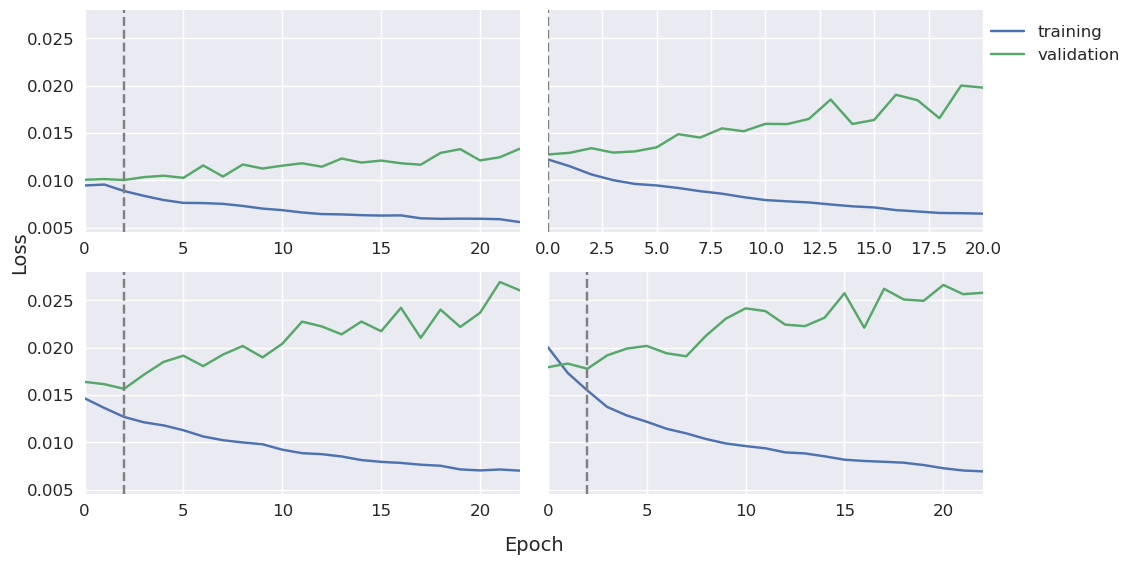

In [69]:
plt.style.use('seaborn')

MODEL = 'sera_3_1000'

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,6),sharey=True)
axes = fig.add_subplot(111)
axes._frameon = False
axes.get_xaxis().set_ticks([])
axes.get_yaxis().set_ticks([])
axes.get_xaxis().set_ticklabels([])
axes.get_yaxis().set_ticklabels([])
axes.set_xlabel('Epoch', fontsize=14, labelpad=30)
axes.set_ylabel('Loss', fontsize=14, labelpad=40)


mins=[]

for i in range(4):
    avg_train_loss = np.load(root + 'save_model/%s/cv%s/avg_train_losses.npy'%(MODEL, i))
    avg_valid_loss = np.load(root + 'save_model/%s/cv%s/avg_valid_losses.npy'%(MODEL, i))
        
    indx = np.where(avg_valid_loss==min(avg_valid_loss))[0][0]
    mins.append(min(avg_valid_loss))
    
    #ax = fig.add_subplot(2,2,i+1)
    if i==0: 
        ax=ax1
    elif i==1: 
        ax=ax2
    elif i==2: 
        ax=ax3
    elif i==3:
        ax=ax4    
    
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.plot(avg_train_loss, label='training')
    ax.plot(avg_valid_loss, label='validation')
    ax.axvline(x=indx,ls='--',c='grey')
    #ax.text(x=indx+0.4, y=0.052, s=indx, fontsize=12)
    ax.set_xlim(0, len(avg_train_loss)-1)
    if i==1:
        ax.legend(loc='upper right',fontsize=12, bbox_to_anchor=(1.35, 1.))
    #ax.set_title('Train and validation losses')

plt.tight_layout()
#plt.savefig(plot_root + 'loss_curves.png')
plt.show()

plt.close()

In [42]:
print(np.round(np.mean(mins),3),'+/-',np.round(np.std(mins),3))

0.128 +/- 0.02


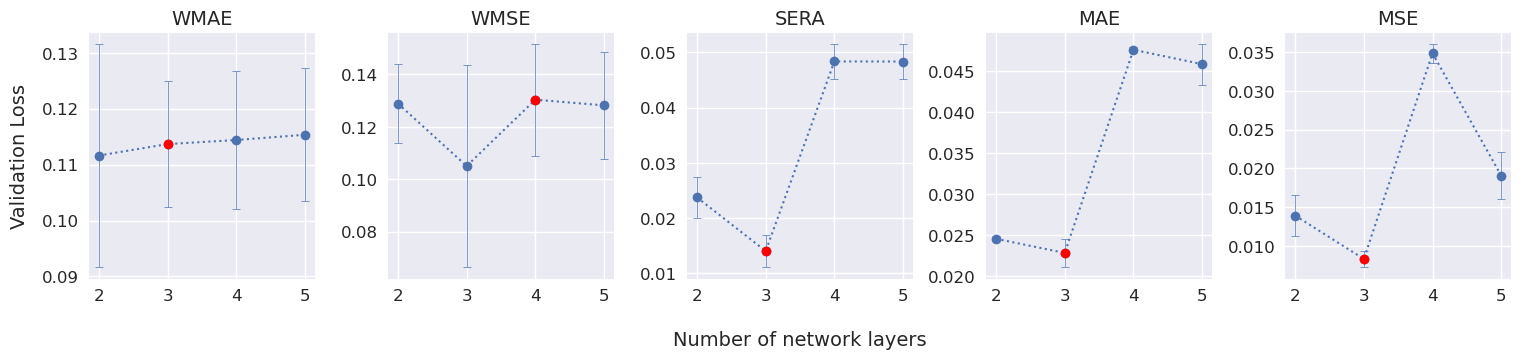

In [65]:
plt.style.use('seaborn')

fig, axes = plt.subplots(2,5,figsize=(16,4))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Number of network layers',fontsize=14,labelpad=20)
plt.ylabel('Validation Loss',fontsize=14,labelpad=20)

best_models = [3,4,3,3,3]

for i, model in enumerate(['wmae','wmse','sera','mae','mse']):

    mins=[]

    for num_layer in [2,3,4,5]:
        model_name = model+'_'+str(num_layer)+'_1000'

        mins_=[]

        for j in range(4):
            avg_train_loss = np.load(root + 'save_model/%s/cv%s/avg_train_losses.npy'%(model_name, j))
            avg_valid_loss = np.load(root + 'save_model/%s/cv%s/avg_valid_losses.npy'%(model_name, j))

            indx = np.where(avg_valid_loss==min(avg_valid_loss))[0][0]
            mins_.append(min(avg_valid_loss))

        mins.append(mins_)
        
    axes[i].tick_params(axis='both', which='major', labelsize=12)    
    axes[i].set_title(['WMAE','WMSE','SERA','MAE','MSE'][i],fontsize=14)
    axes[i].errorbar([2,3,4,5],[np.mean(_) for _ in mins],
                     yerr=[np.std(_) for _ in mins],
                     ls=':',
                     marker='o',
                     linewidth=1.5,
                     elinewidth=0.5, 
                     capsize=3,
                     capthick=0.5,
                     zorder=1,
                    )
    l=best_models[i]
    val=[np.mean(_) for _ in mins][l-2]
    axes[i].plot([l],[val],marker='o',c='red',zorder=2)
    
plt.tight_layout()
plt.savefig(plot_root+'validation_loss_comparison.png')
plt.show()

In [175]:
from encoder import Encoder
from decoder import Decoder
from model import ED
from net_params import convlstm_encoder_params, convlstm_decoder_params, convgru_encoder_params, convgru_decoder_params
from data_loader import load_era5

def function_hist(a, ini, final):
    # 100 bins
    bins = np.linspace(ini, final, final-ini+1)
    #weightsa = np.ones_like(a)/float(len(a))
    hist, bin_edges = np.histogram(np.array(a), bins) #weights = weightsa)
    return hist, bins

MODEL = 'sera_3_1000'

args.hpa=1000

n_preds = []

for i in range(4):
    
    print('\ncv:',i,'\t started.')
    encoder_params = convlstm_encoder_params
    decoder_params = convlstm_decoder_params
    encoder = Encoder(encoder_params[0], encoder_params[1]).cuda()
    decoder = Decoder(decoder_params[0], decoder_params[1]).cuda()
    net = ED(encoder, decoder)
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)
    model_info = torch.load(os.path.join(root + 'save_model/%s/cv%s'%(MODEL,i), 'checkpoint.pth.tar'))
    net = ED(encoder, decoder)
    net.load_state_dict(model_info['state_dict'])
    net.eval()
    _, _, test_loader = load_era5(root=data_root, args=args, a=0.6, b=0.8, c=0.8)
    _, targets, predictions, _, _, _ = utils.predict_batchwise(test_loader, net, device, report=False)
    
    if i==0:
        n_t, bins = function_hist(targets, -3, 12)
    n_p, bins = function_hist(predictions, -3, 12)
    n_preds.append(n_p)


cv: 0 	 started.
number of years: 10.0
percentiles: 1.4 2.8

cv: 1 	 started.
number of years: 10.0
percentiles: 1.4 2.8

cv: 2 	 started.
number of years: 10.0
percentiles: 1.4 2.8

cv: 3 	 started.
number of years: 10.0
percentiles: 1.4 2.8


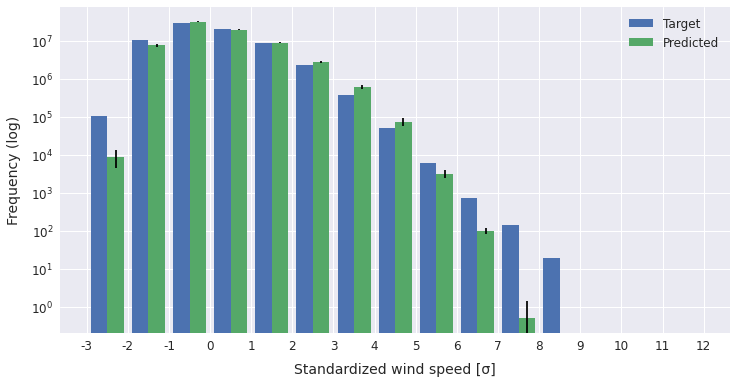

In [65]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(bins[:-1]+0.1, n_t, width=0.4, label='Target', align='edge')
ax.bar(bins[:-1]+0.5, np.array(n_preds).mean(0), width=0.4, yerr=np.array(n_preds).std(0),capsize=3,error_kw={'capthick':'0'}, label='Predicted',align='edge')
ax.legend(loc='upper right',fontsize=12)
ax.set_xlabel('Standardized wind speed [σ]',fontsize=14, labelpad=10)
ax.set_ylabel('Frequency (log)',fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yscale('log')
ax.set_xticks(np.arange(-3,13,1))
ax.set_xticklabels(np.arange(-3,13,1))

#plt.savefig(plot_root + 'class_distribution_MSE.png')
plt.show()

In [994]:
# model_names = [
#     ['cnn_regr60', 'W-MAE'],
#     ['cnn_regr61', 'W-MSE'],
#     #['cnn_regr64', 'SERA (old)'],
#     ['cnn_regr73', 'SERA'],
#     ['cnn_regr75', 'MAE'],
#     ['cnn_regr74', 'MSE'],
#     #['cnn_regr_null','Null'],
#     #['cnn_regr_pers', 'Persistence'],
# ]

# model_names = [
#     ['cnn_regr70', 'lr=1e-2'],
#     ['cnn_regr60', 'lr=1e-3'],
#     ['cnn_regr71', 'lr=1e-4'],
# ]

# model_names = [
#     ['cnn_regr61', 'W-MSE_1'],
#     ['cnn_regr61_1', 'W-MSE_2'],
#     ['cnn_regr61_2', 'W-MSE_3'],
#     ['cnn_regr61_3', 'W-MSE_4'],
# ]

model_names = [
    ['cnn_regr72', '2 layers'],
    ['cnn_regr60', '3 layers'],
    ['cnn_regr62', '4 layers'],
    ['cnn_regr63', '5 layers'],
]

# model_names = [
#     ['cnn_regr62', '4-layered W-MAE'],
#     ['cnn_regr76', '4-layers MAE'],
#     ['cnn_regr_pers', 'Persistence'],
# ]



score_names = ['SEDI','PSS','CSS','Recall','Precision','F1','FSS','ISS']

## Minimum training loss over all splits

In [996]:
means = np.zeros(4)
stds = np.zeros(4)

for i, name in enumerate(model_names): 
    avg_valid_loss = []
    loss = np.load(root + 'save_model/%s/avg_valid_losses.npy'%name[0])
    avg_valid_loss.append(min(loss))
    for j in range(1,4):
        loss = np.load(root + 'save_model/%s_%s/avg_valid_losses.npy'%(name[0],j))
        avg_valid_loss.append(min(loss))

    means[i] = np.mean(avg_valid_loss)
    stds[i] = np.std(avg_valid_loss)
    print(np.mean(avg_valid_loss),'+/-', np.std(avg_valid_loss))

0.08361733341589571 0.005972998020574067
0.08668987927320476 0.0027955649903024004
0.08490415759359116 0.002222095414464724
0.08596343962246017 0.0027195018294365976


## Score comparison over all splits

0.009308103605758563
0.019192873739585916
0.01778502743149494
0.021453290409274812
0.01851454353692143
0.010885037542665496
0.02273153157026165
0.0284885326556684


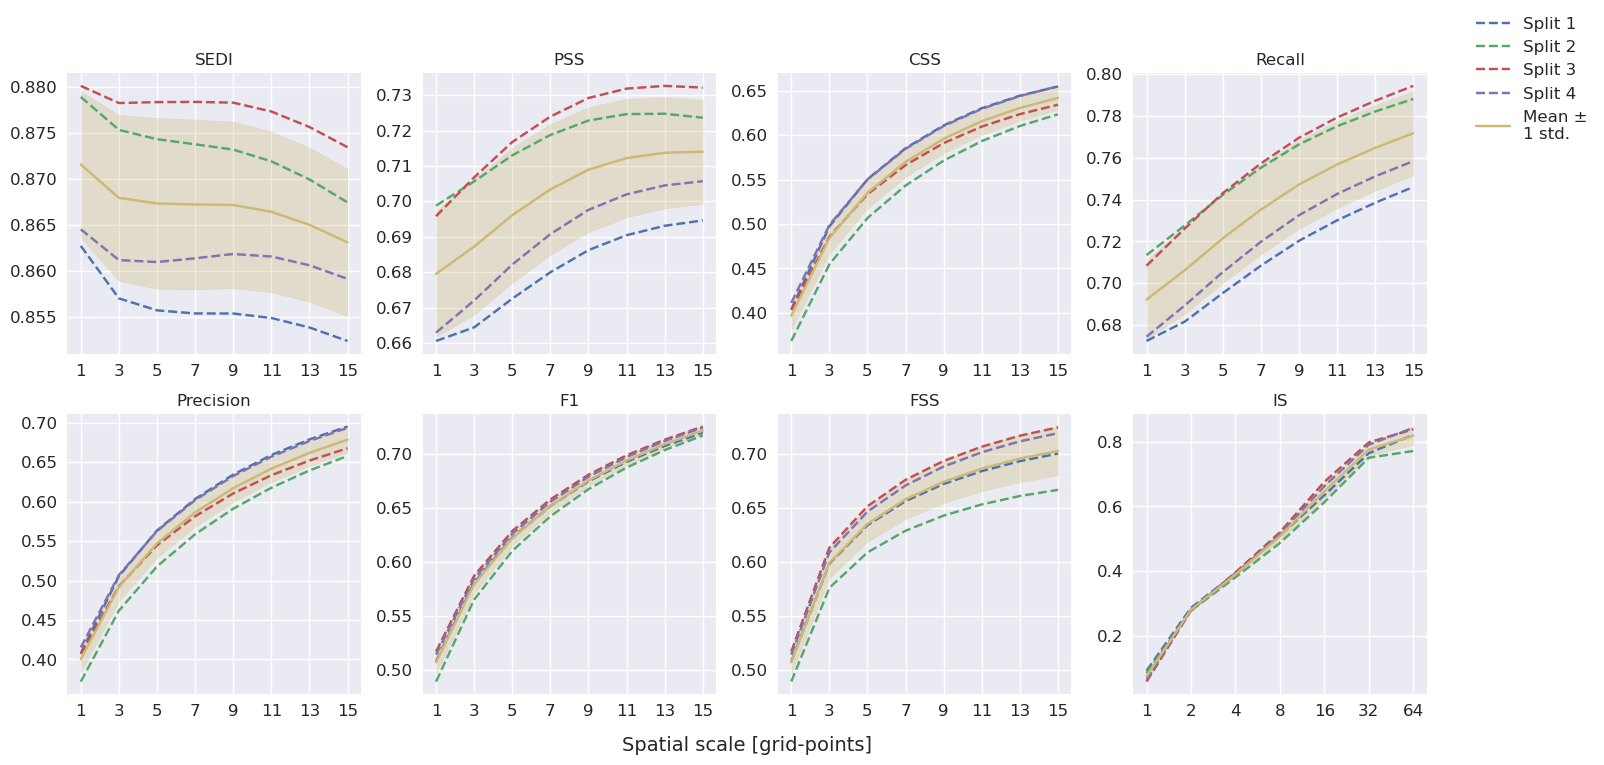

In [690]:
scores_splits = np.zeros((4,8,8))

for i, (name, label) in enumerate(model_names): 
    scores_scales = pickle.load(open(root + "saved_scores/scores_scales_%s_test.p"%name, 'rb'))
    scores_splits[i] = scores_scales
    
#plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn')

fig, axes = plt.subplots(2,4,figsize=(16,8))

ax = fig.add_subplot(111,frameon=False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
plt.xlabel('Spatial scale [grid-points]',fontsize=14,labelpad=30)

for i, label in enumerate(['Split 1','Split 2','Split 3','Split 4','Mean ±\n1 std.']): 
    
    if i==4:
        scores_scales = scores_splits[:].mean(0)
        stds_scales = scores_splits[:].std(0)
    else:
        scores_scales = scores_splits[i]
    
    for p1 in range(2):
        for p2 in range(4):
            c = 4*p1+p2
            ax = axes[p1,p2]
            ax.set_title(score_names[c])
            if c==7:
                scales = [1,2,4,8,16,32,64]
                values = np.flip(scores_scales[c][:-1])
                if i==4: 
                    stds = np.flip(stds_scales[c][:-1])
                ax.set_xscale('log')
                ax.set_xticks(scales)
                ax.set_xticklabels(scales)
            else: 
                scales = [1,3,5,7,9,11,13,15]
                values = np.flip(scores_scales[c])
                if i==4: 
                    stds = np.flip(stds_scales[c])
                ax.set_xticks(scales)
                ax.set_xticklabels(scales)
            
        
            if i==4:
                color=next(ax._get_lines.prop_cycler)['color']
                ax.plot(scales, values, color=color, label=label)
                ax.fill_between(scales, values-stds, values+stds, alpha=0.3, color=color)
            else:
                ax.plot(scales, values, ls='--', label=label)
            if c==3:
                #ax.legend(loc=4, bbox_to_anchor=(1.4, 0.76), fancybox=True)
                leg = ax.legend(loc=4, fontsize=12, bbox_to_anchor=(1.6, 0.7), fancybox=True)
                leg.get_title().set_fontsize('12')
            ax.grid(True)
            
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            if i==4:
                print(stds.max())
            

plt.tight_layout()
#plt.savefig(plot_root + 'model_comparison3_scales.png')

plt.show()

0.017843538780019094
0.03794084886942287
0.04285914430919061
0.04541767630411899
0.04435391798554657
0.017002231995807048
0.054843020168867544
0.11169769463951433


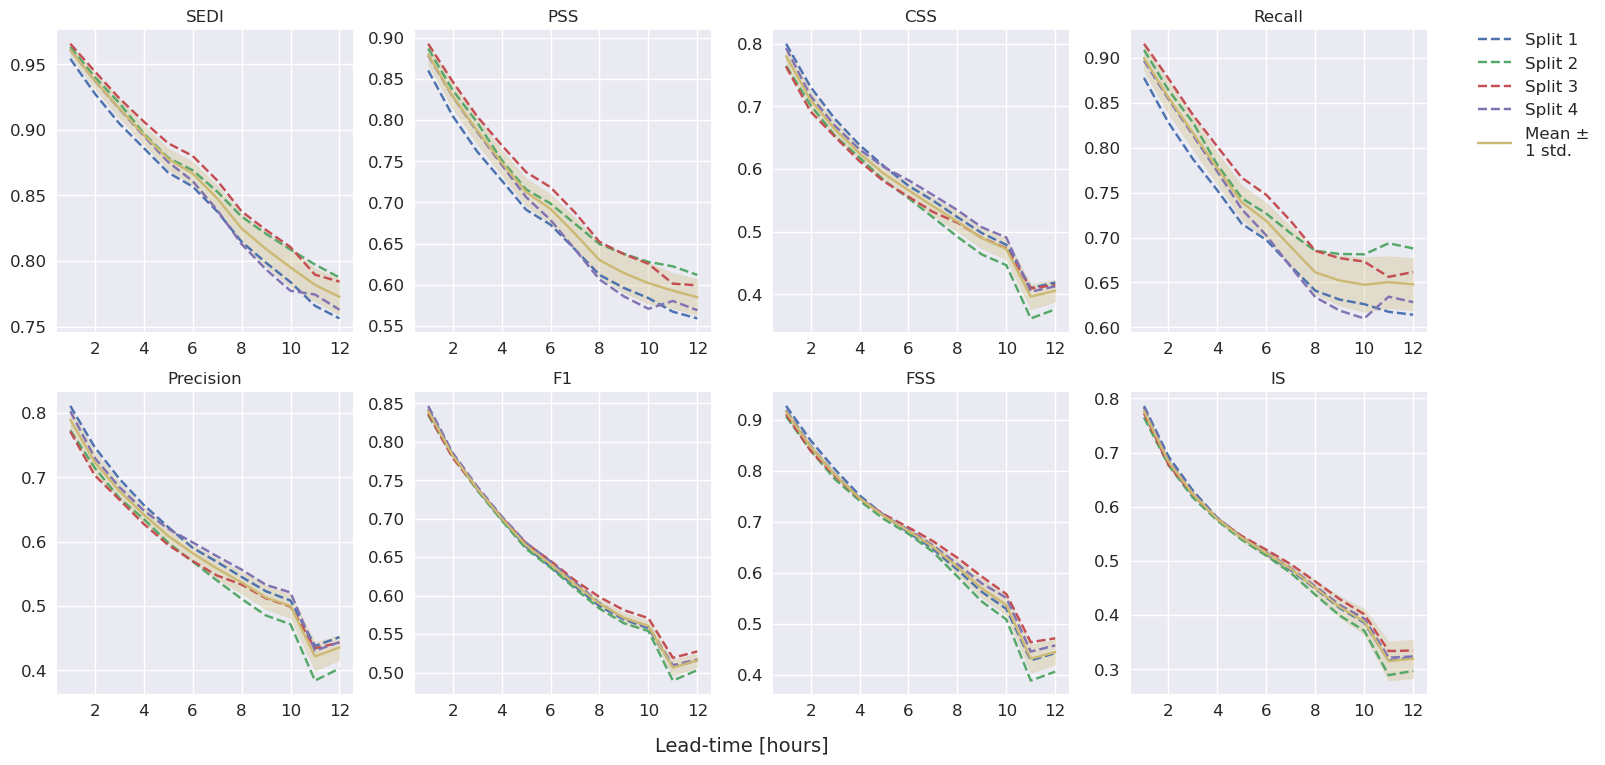

In [691]:
scores_splits = np.zeros((4,8,8,12))

for i, (name, label) in enumerate(model_names): 
    scores_times = pickle.load(open(data_root + 'saved_scores/scores_times_%s_test.p'%name,'rb'))
    scores_splits[i] = scores_times

fig, axes = plt.subplots(2,4,figsize=(16,8))

ax = fig.add_subplot(111,frameon=False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
plt.xlabel('Lead-time [hours]',fontsize=14,labelpad=30)

for i, label in enumerate(['Split 1','Split 2','Split 3','Split 4','Mean ±\n1 std.']): 
    
    if i==4:
        scores_times = scores_splits[:].mean(0)
        stds_times = scores_splits[:].std(0)
    else:
        scores_times = scores_splits[i]
        
    for p1 in range(2):
        for p2 in range(4):
            c = 4*p1+p2
            ax = axes[p1,p2]
            ax.set_title(score_names[c])
            
            if c == 7: 
                values = scores_times[c,:-1].mean(0) 
                if i==4: 
                    stds = stds_times[c][:-1].mean(0)
            else: 
                values = scores_times[c].mean(0)  
                if i==4: 
                    stds = stds_times[c].mean(0)
                    
            ax.set_xticks(np.arange(2,13,2))
            ax.set_xticklabels(np.arange(2,13,2))
        
            if i==4:
                color=next(ax._get_lines.prop_cycler)['color']
                ax.plot(np.arange(1,13), values, color=color, label=label)
                ax.fill_between(np.arange(1,13), values-stds, values+stds, alpha=0.3, color=color)
            else:
                ax.plot(np.arange(1,13), values, ls='--', label=label)
                
            if c==3:
                leg = ax.legend(loc=1, fontsize=12, bbox_to_anchor=(1.6, 1.04), fancybox=True)
                leg.get_title().set_fontsize('12')
            ax.grid(True)
            
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            if i==4:
                print(stds[-1]/values[-1])

plt.xticks(fontsize=12)
plt.tight_layout()
#plt.savefig(plot_root + 'model_comparison3_times.png')
            
plt.show()

## Relative improvements

In [327]:
all_scores = np.zeros((5,4,4,8,8))

for i, (name, label) in enumerate(model_names): 

    scores_splits = np.zeros((4,4,8,8))
    scores_splits[0] = pickle.load(open(root + "saved_scores/scores_scales_%s_test_thresholds.p"%name,'rb'))
    for j in range(1,4):
        scores_splits[j] = pickle.load(open(root + 'saved_scores/scores_scales_%s_%s_test_thresholds.p'%(name,j),'rb'))

    all_scores[i] = scores_splits

In [328]:
scores = np.zeros((3,4,4,8,8))

for i in range(3): 
    for j in range(4):
        scores[i,j,:,:,:] = all_scores[i,j,:,:,:]-all_scores[-1,j,:,:,:]

In [329]:
means = np.zeros((3,4,8))
stds = np.zeros((3,4,8))

for c in range(3):
    for t in range(4):
        for s in range(8):
            if s==7:
                means[c,t,s] = scores[c,:,t,s,:-1].mean(axis=(0,1))
                stds[c,t,s] = scores[c,:,t,s,:-1].std(axis=(0,1))
            else: 
                means[c,t,s] = scores[c,:,t,s,:].mean(axis=(0,1)) 
                stds[c,t,s] = scores[c,:,t,s,:].std(axis=(0,1))

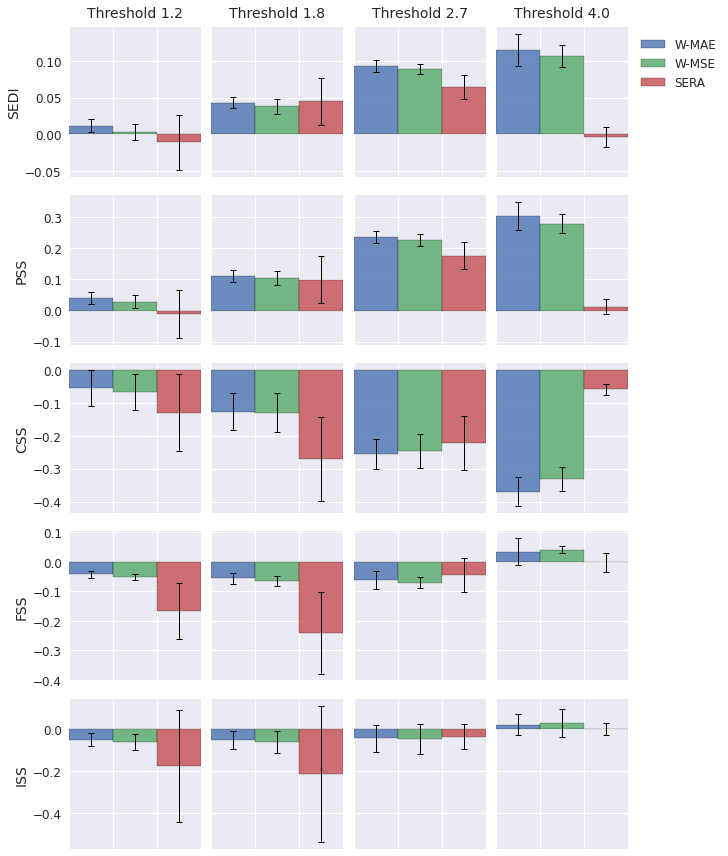

In [347]:
fig, axes = plt.subplots(5,4,figsize=(10,12),sharex=False, sharey='row')

for i, s in enumerate([0,1,2,6,7]):
    for j, t in enumerate([1.2,1.8,2.7,4.0]):

        ax = axes[i,j]
        if j==0:
            ax.set_ylabel(score_names[s],fontsize=14)
        if i==0:
            ax.set_title('Threshold %s'%t, fontsize=14, pad=10)
        for l, label in enumerate(['W-MAE','W-MSE','SERA']):
            ax.bar(l,means[l,j,s],yerr=stds[l,j,s],label=label,width=1,edgecolor='black',align='edge',alpha=0.8,error_kw=dict(lw=1, capsize=3, capthick=1))
        ax.set_xticklabels([])
        ax.set_xlim(0,3)
        
        ax.tick_params(axis='both', which='major', labelsize=12)

        if i==0and j==3:
            ax.legend(loc=1, fontsize=12, fancybox=True, bbox_to_anchor=(1.75, 1.0))
plt.tight_layout()
plt.savefig(plot_root+'bars_comparison.png')
plt.show()

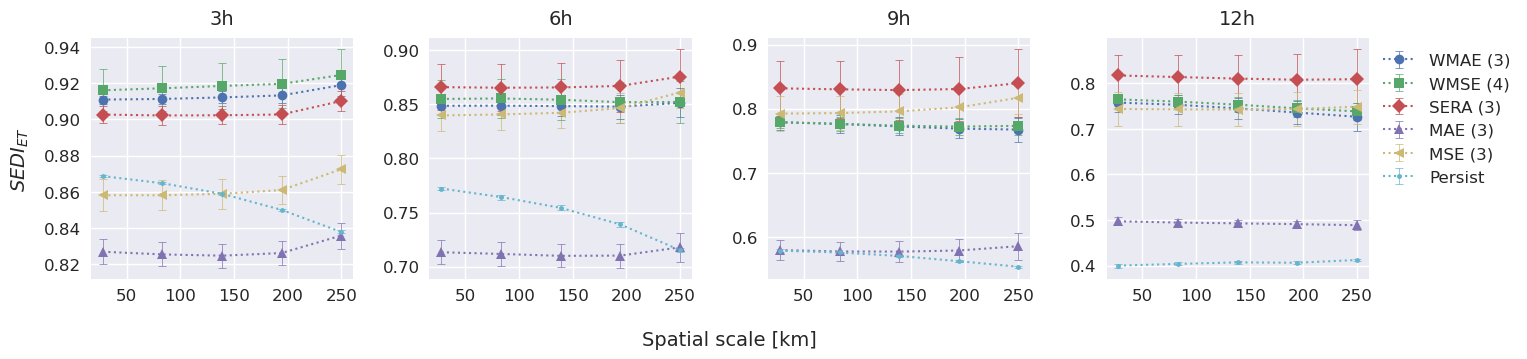

In [306]:
#plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn')

fig, axes = plt.subplots(1,4,figsize=(16,4), sharex=True)
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Spatial scale [km]', fontsize=14, labelpad=20)
plt.ylabel(r'$SEDI_{ET}$', fontsize=14, labelpad=20)

model_names = [['wmae_3','WMAE (3)'],
               ['wmse_4','WMSE (4)'],
               ['sera_3','SERA (3)'],
               ['mae_3','MAE (3)'],
               ['mse_3','MSE (3)'],
               ['persist','Persist'],
              ]
              

markers = ['o','s','D','^','<','.']
    
for p, t in enumerate([2,5,8,11]):
    
    ax = axes[p]
    ax.set_title(str(t+1)+'h', fontsize=14, pad=10)
    

    for i, (name, label) in enumerate(model_names): 

        scores_splits = np.zeros((4,5,12))
        for j in range(4):
            scores_splits[j] = np.load(root + 'save_scores_random/%s_1000/scores_times_%s.npy'%(name,j))

        scores_splits = np.nan_to_num(scores_splits, nan=0.0)

        scores_scales = scores_splits[:,:,t].mean(0)
        stds_scales = scores_splits[:,:,t].std(0)


        scales = np.array([1,3,5,7,9])*111/4
        values = np.flip(scores_scales)
        stds = np.flip(stds_scales)
        ax.set_xticks([50,100,150,200,250])
        ax.set_xticklabels([50,100,150,200,250])

        #ax.plot(scales, values, linewidth=1.5, label=label)
        #ax.fill_between(scales, values-stds, values+stds, alpha=0.15)
        ax.errorbar(scales, values,ls=':',marker=markers[i],linewidth=1.5,label=label, yerr=stds, elinewidth=0.5, capsize=3,capthick=0.5)
   
        ax.tick_params(axis='both', which='major', labelsize=12)

    if p==3:
        ax.legend(loc=1, fontsize=12, fancybox=True, bbox_to_anchor=(1.6, 1.0))
    
    

plt.tight_layout()
#plt.savefig(plot_root + 'model_comparison_persist.png')

plt.show()

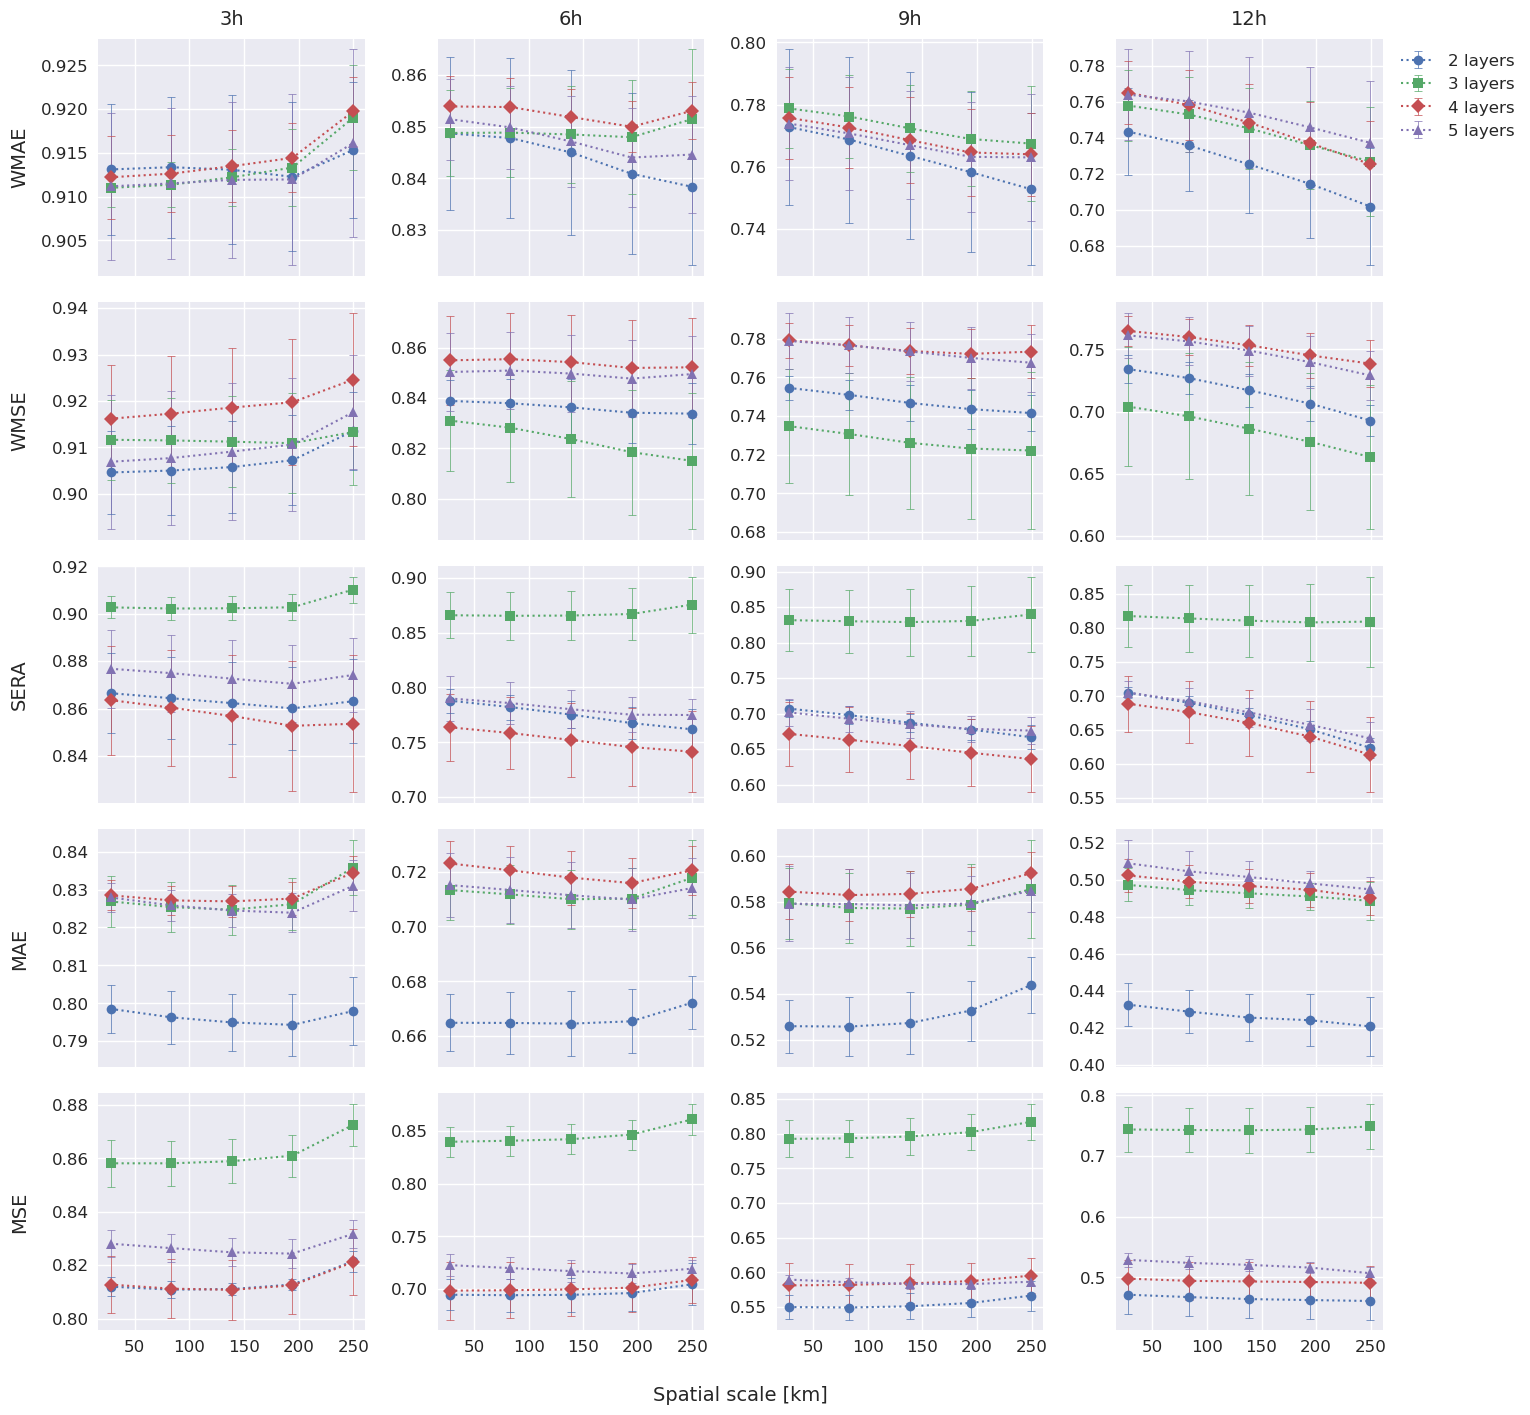

In [305]:
#plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn')

fig, axes = plt.subplots(5,1,figsize=(16,14.5), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    #ax = fig.add_subplot(111,frameon=False)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
plt.xlabel('Spatial scale [km]',fontsize=14,labelpad=40)
#plt.ylabel('Score',fontsize=20,labelpad=50)
    
model_names = [['wmae','WMAE'],
               ['wmse','WMSE'],
               ['sera','SERA'],
               ['mae','MAE'],
               ['mse','MSE']]

markers = ['o','s','D','^']


for a, (name, label) in enumerate(model_names):
    
    colors = []
    #if s==0:
    #    axes[s].set_title(score,fontsize=15,pad=30)       
    #else: 
    #    axes[s].set_title(score,fontsize=15,pad=20)  
    
    axes[a].set_ylabel(label,fontsize=14,labelpad=50)
    
    for c in range(4):
        ax = fig.add_subplot(len(model_names),4,4*a+c+1)   
        t = [2,5,8,11][c]
        if a==0:
            ax.set_title(str(t+1)+'h', fontsize=14,pad=10)
        
        for i, num_layers in enumerate([2,3,4,5]): 

            scores_splits = np.zeros((4,5,12))
            for j in range(4):
                scores_splits[j] = np.load(root + 'save_scores_random/%s_%s_1000/scores_times_%s.npy'%(name,num_layers,j))
            
            scores_splits = np.nan_to_num(scores_splits, nan=0.0)
            #print(scores_splits)
            
            scores_scales = scores_splits[:,:,t].mean(0)
            stds_scales = scores_splits[:,:,t].std(0)

            scales = np.array([1,3,5,7,9])*111/4
            values = np.flip(scores_scales)
            stds = np.flip(stds_scales)
            if a==4: 
                ax.set_xticks([50,100,150,200,250])
                ax.set_xticklabels([50,100,150,200,250])
            else: 
                ax.set_xticks([50,100,150,200,250])
                ax.set_xticklabels([])

            #ax.plot(scales, values, linewidth=1.5, label=label)
            #ax.fill_between(scales, values-stds, values+stds, alpha=0.15)
            ax.errorbar(scales, values, ls=':',marker=markers[i],linewidth=1.5,label='%s layers'%num_layers, yerr=stds, elinewidth=0.5, capsize=3,capthick=0.5)
    
            if a==0 and c==3:
                ax.legend(loc=1, fontsize=12, fancybox=True, bbox_to_anchor=(1.55, 1.0))

            #ax.grid(True)
            ax.tick_params(axis='both', which='major', labelsize=12)

            

plt.tight_layout()
#plt.savefig(plot_root + 'model_comparison_layers_persist.png')

plt.show()

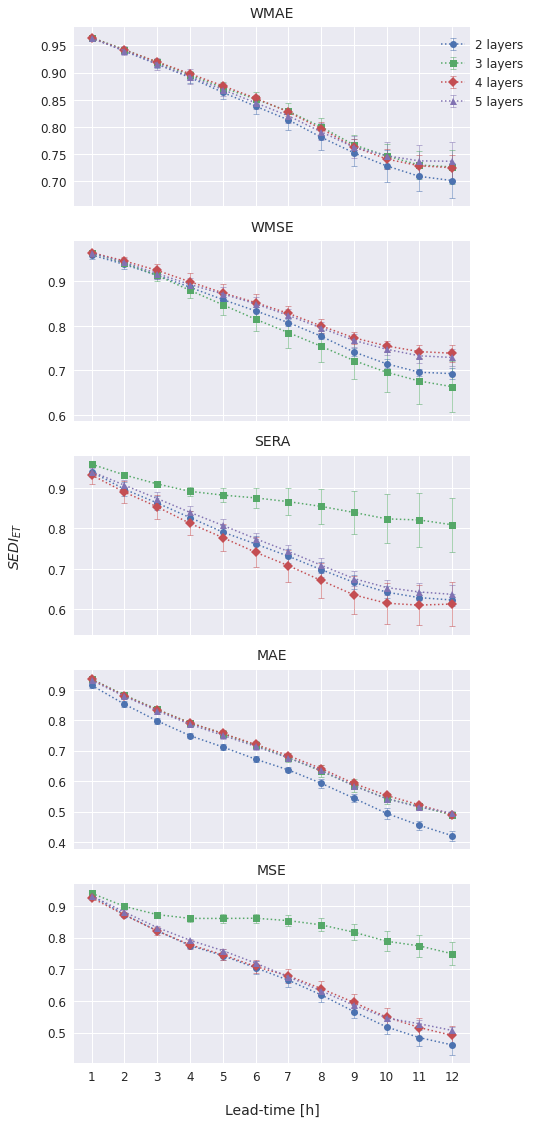

In [8]:
#plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn')

fig, axes = plt.subplots(5,1,figsize=(8,16), sharex=True, sharey=False)

ax = fig.add_subplot(111,frameon=False)
ax._frameon = False
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])

plt.xlabel('Lead-time [h]',fontsize=14,labelpad=40)
plt.ylabel(r'$SEDI_{ET}$',fontsize=14,labelpad=50)
    
model_names = [['wmae','WMAE'],
               ['wmse','WMSE'],
               ['sera','SERA'],
               ['mae','MAE'],
               ['mse','MSE']]

markers = ['o','s','D','^']


for a, (name, label) in enumerate(model_names):
    
    colors = []
    #if s==0:
    #    axes[s].set_title(score,fontsize=15,pad=30)       
    #else: 
    #    axes[s].set_title(score,fontsize=15,pad=20)  
    
    ax = axes[a]
    ax.set_title(label,fontsize=14,pad=10)
    
        
    for i, num_layers in enumerate([2,3,4,5]): 

        scores_splits = np.zeros((4,5,12))
        for j in range(4):
            scores_splits[j] = np.load(root + 'save_scores_random/%s_%s_1000/scores_times_%s.npy'%(name,num_layers,j))

        scores_splits = np.nan_to_num(scores_splits, nan=0.0)
        #print(scores_splits)

        scores_scales = scores_splits[:,0,:].mean(0)
        stds_scales = scores_splits[:,0,:].std(0)

        #scales = np.array([1,3,5,7,9])*111/4
        values = scores_scales#np.flip(scores_scales)
        stds = stds_scales#np.flip(stds_scales)
        if a==4: 
            ax.set_xticks(np.arange(1,13))
            ax.set_xticklabels(np.arange(1,13))
        else: 
            ax.set_xticks(np.arange(1,13))
            ax.set_xticklabels([])

        #ax.plot(scales, values, linewidth=1.5, label=label)
        #ax.fill_between(scales, values-stds, values+stds, alpha=0.15)
        ax.errorbar(np.arange(1,13), values, ls=':',marker=markers[i],linewidth=1.5,label='%s layers'%num_layers, yerr=stds, elinewidth=0.5, capsize=3,capthick=0.5)

        if a==0:
            ax.legend(loc=1, fontsize=12, fancybox=True, bbox_to_anchor=(1.16, 1.0))

        #ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=12)

            

plt.tight_layout()
#plt.savefig(plot_root + 'model_comparison_layers_persist.png')

plt.show()

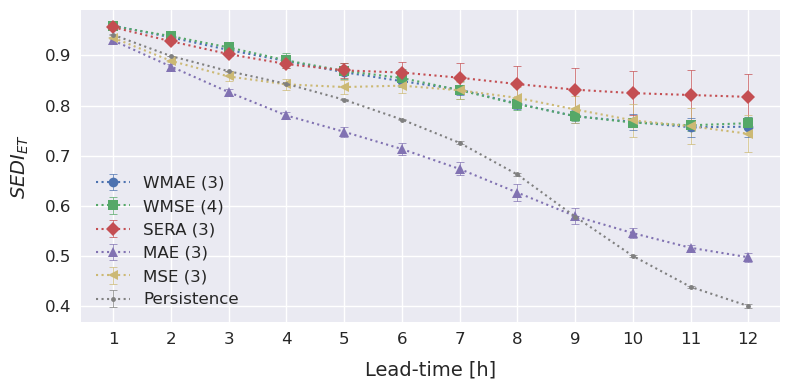

In [6]:
#plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn')

fig,ax = plt.subplots(figsize=(8,4))

plt.xlabel('Lead-time [h]',fontsize=14,labelpad=10)
plt.ylabel(r'$SEDI_{ET}$',fontsize=14,labelpad=10)
    
model_names = [['wmae_3','WMAE (3)'],
               ['wmse_4','WMSE (4)'],
               ['sera_3','SERA (3)'],
               ['mae_3','MAE (3)'],
               ['mse_3','MSE (3)'],
               ['persist','Persistence']]

markers = ['o','s','D','^','<','.']


for a, (name, label) in enumerate(model_names):
    
    colors = []
    #if s==0:
    #    axes[s].set_title(score,fontsize=15,pad=30)       
    #else: 
    #    axes[s].set_title(score,fontsize=15,pad=20)  
        

    scores_splits = np.zeros((4,5,12))
    for j in range(4):
        scores_splits[j] = np.load(root + 'save_scores_random/%s_1000/scores_times_%s.npy'%(name,j))

    scores_splits = np.nan_to_num(scores_splits, nan=0.0)
    #print(scores_splits)

    scores_scales = scores_splits[:,-1,:].mean(0)
    stds_scales = scores_splits[:,-1,:].std(0)

    #scales = np.array([1,3,5,7,9])*111/4
    values = scores_scales#np.flip(scores_scales)
    stds = stds_scales#np.flip(stds_scales)

    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(np.arange(1,13))

    #ax.plot(scales, values, linewidth=1.5, label=label)
    #ax.fill_between(scales, values-stds, values+stds, alpha=0.15)
    if a == 5:
        ax.errorbar(np.arange(1,13), values, c='gray', ls=':',marker=markers[a],linewidth=1.5,label=label, yerr=stds, elinewidth=0.5, capsize=3,capthick=0.5)
    else:
        ax.errorbar(np.arange(1,13), values, ls=':',marker=markers[a],linewidth=1.5,label=label, yerr=stds, elinewidth=0.5, capsize=3,capthick=0.5)
 
    ax.legend(loc=0, fontsize=12, fancybox=True)#, bbox_to_anchor=(1.1, 1.0))

    #ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=12)

            

plt.tight_layout()
plt.savefig(plot_root + 'model_comparison_times.png')

plt.show()

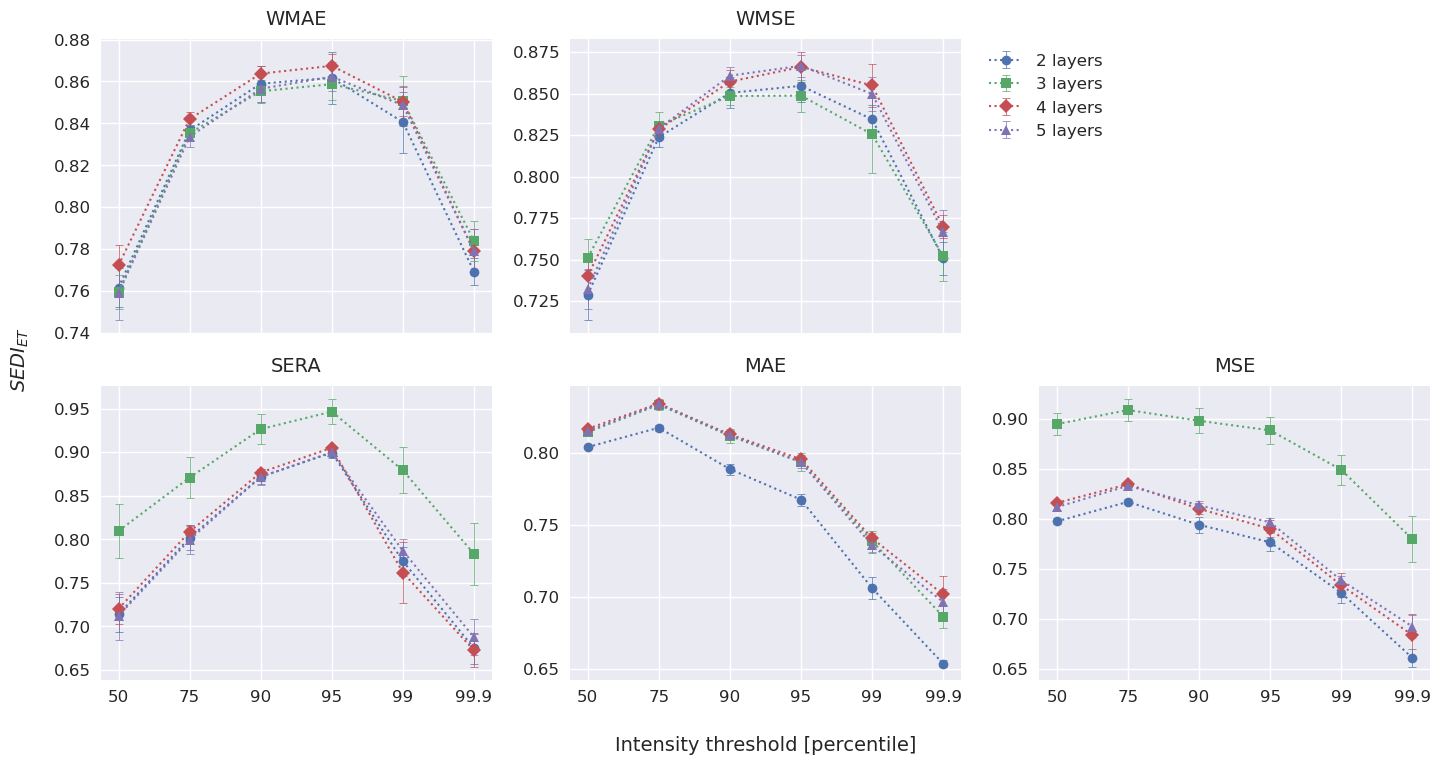

In [11]:
#plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn')

fig, axes = plt.subplots(figsize=(15,8), sharex=True, sharey=False)

axes._frameon = False
axes.get_xaxis().set_ticks([])
axes.get_yaxis().set_ticks([])
axes.get_xaxis().set_ticklabels([])
axes.get_yaxis().set_ticklabels([])

plt.xlabel('Intensity threshold [percentile]',fontsize=14,labelpad=40)
plt.ylabel(r'$SEDI_{ET}$',fontsize=14,labelpad=50)
    
model_names = [['wmae','WMAE'],
               ['wmse','WMSE'],
               ['sera','SERA'],
               ['mae','MAE'],
               ['mse','MSE']]

markers = ['o','s','D','^']


for k, (name, label) in enumerate(model_names):
    a = [0,1,3,4,5][k]
    
    ax = fig.add_subplot(2,3,a+1)
    ax.set_title(label,fontsize=14,pad=10)
    
        
    for i, num_layers in enumerate([2,3,4,5]): 

        scores_splits = np.zeros((4,6,5))
        for j in range(4):
            scores_splits[j] = np.load(root + 'save_scores_random/%s_%s_1000/scores_scales_extended_%s.npy'%(name,num_layers,j))

        scores_splits = np.nan_to_num(scores_splits, nan=0.0)

        means = scores_splits.mean(0)[:,0]
        stds = scores_splits.std(0)[:,0]

        if a==3 or a==4 or a==5: 
            ax.set_xticks(np.arange(1,7))
            ax.set_xticklabels(['50','75','90','95','99','99.9'])
        else: 
            ax.set_xticks(np.arange(1,7))
            ax.set_xticklabels([])

        ax.errorbar(np.arange(1,7), means,  yerr=stds, ls=':', marker=markers[i], linewidth=1.5, label='%s layers'%num_layers, elinewidth=0.5, capsize=3, capthick=0.5)

        if a==1:
            ax.legend(loc=1, fontsize=12, fancybox=True, bbox_to_anchor=(1.4, 1.0))

        #ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=12)


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
plt.savefig(plot_root + 'model_comparison_layers.png')

plt.show()

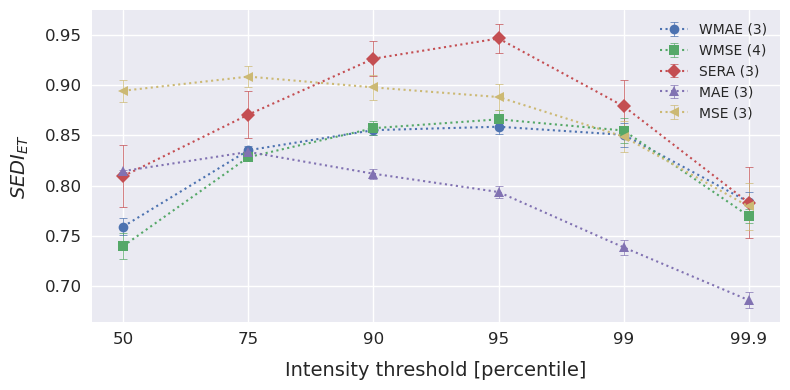

In [20]:
plt.style.use('seaborn')

models = ['wmae_3','wmse_4','sera_3','mae_3','mse_3']
model_names = ['WMAE (3)','WMSE (4)','SERA (3)','MAE (3)','MSE (3)']

markers = ['o','s','D','^','<']

scores_mean = []
scores_std = []

fig, ax = plt.subplots(figsize=(8,4))

ax.set_xlabel('Intensity threshold [percentile]',fontsize=14,labelpad=10)
ax.set_ylabel(r'$SEDI_{ET}$',fontsize=14,labelpad=10)


for i, model in enumerate(models):
    scores_splits = np.zeros((4,6,5))
    for j in range(4):
        scores_splits[j] = np.load(root + 'save_scores_random/%s_1000/scores_scales_extended_%s.npy'%(model,j))

    scores_splits = np.nan_to_num(scores_splits, nan=0.0)

    means = scores_splits.mean(0)[:,0]
    stds = scores_splits.std(0)[:,0]
    
    ax.errorbar(['50','75','90','95','99','99.9'], means, yerr=stds, label=model_names[i], ls=':', marker=markers[i], linewidth=1.5, elinewidth=0.5, capsize=3, capthick=0.5)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc=1, fancybox=True,) #bbox_to_anchor=(1.35, 1.0))

plt.tight_layout()
plt.savefig(plot_root + 'model_comparison_complete.png')
plt.show()
    
    

[[3.95910720e-05 1.88050563e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.28656576e-05 3.31303145e-05 1.09477703e-04 3.76097732e-03
  0.00000000e+00]
 [4.52913422e-05 4.89707485e-05 1.34974489e-04 1.67449028e-04
  3.35187680e-04]
 [9.54244938e-05 2.09849461e-04 1.73366901e-04 1.90834817e-04
  3.00196160e-04]
 [1.01560918e-04 2.66464349e-04 3.47889195e-04 4.82996430e-04
  6.99129191e-04]
 [2.23639394e-03 2.10295675e-03 1.93510106e-03 2.12314814e-03
  1.95248851e-03]]


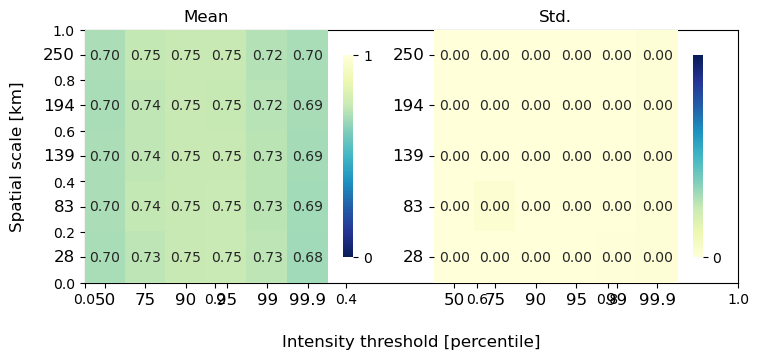

In [54]:
model = 'persist_1000'

scores_splits = np.zeros((4,6,5))
for j in range(4):
    scores_splits[j] = np.load(root + 'save_scores_random/%s/scores_scales_extended_%s.npy'%(model,j))

scores_splits = np.nan_to_num(scores_splits, nan=0.0)

scores_scales = scores_splits.mean(0)
stds_scales = scores_splits.std(0)
print(stds_scales)

plt.style.use('default')

fig, ax = plt.subplots(1,1,figsize=(8, 4))    

plt.ylabel('Spatial scale [km]',fontsize=12,labelpad=20)
plt.xlabel('Intensity threshold [percentile]',fontsize=12, labelpad=20)

thresholds = [50, 75, 90, 95, 99, 99.9]
scales = [int(i) for i in np.round(np.array([9,7,5,3,1])*111/4, 0)]

for i, scores_ in enumerate([scores_scales, stds_scales]):
    axis_label = np.array(scales)
    df = pd.DataFrame(np.zeros((len(scales),len(thresholds))),index=scales, columns=thresholds, dtype=float)
    df = df.set_axis(axis_label, axis=0)
    for k, s in enumerate(scales): 
        df.iloc[k] = scores_[:,k]

    ax = fig.add_subplot(1,2,i+1)
    ax._frameon = True
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

    # plot heatmap
    sb.heatmap(df, annot=True, fmt=".2f", cmap=['YlGnBu_r','YlGnBu'][i] ,
               vmin=0, vmax=[1,0.15][i], cbar_kws={"shrink": .8, "ticks":[0,1]}, annot_kws={"size":10})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)

    ax.set_title(['Mean','Std.'][i],fontsize=12)

    # ticks
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_yticklabels(axis_label, rotation=0, fontsize=12)
    ax.set_xticklabels(thresholds, fontsize=12)

plt.tight_layout()
plt.savefig(plot_root + 'scores_extended_%s.png'%model)
plt.show()


In [14]:
def intensity_scale_diagram(model, title):
    
    scores_splits = np.zeros((4,6,5))
    for j in range(4):
        scores_splits[j] = np.load(root + 'save_scores_random/%s/scores_scales_extended_%s.npy'%(model,j))

    scores_splits = np.nan_to_num(scores_splits, nan=0.0)

    scores_scales = scores_splits.mean(0)
    stds_scales = scores_splits.std(0)
    
    plt.style.use('default')
    
    fig, axes = plt.subplots(1,2,figsize=(8, 4), sharex=True, sharey=True)    
    for i, ax in enumerate(axes):
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])
        
    ax=fig.add_subplot(1,1,1)
    ax.set_title(title, fontsize=12, pad=20)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    
    
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel('Spatial scale [km]',fontsize=12,labelpad=20)
    plt.xlabel('Intensity threshold [percentile]',fontsize=12, labelpad=20)
    #plt.title('SEDI for SERA_3',fontsize=12,pad=20)
    
    thresholds = [50, 75, 90, 95, 99, 99.9]
    scales = [int(i) for i in np.round(np.array([9,7,5,3,1])*111/4, 0)]
    
    for i, scores_ in enumerate([scores_scales, stds_scales]):
        axis_label = np.array(scales)
        df = pd.DataFrame(np.zeros((len(scales),len(thresholds))),index=scales, columns=thresholds, dtype=float)
        df = df.set_axis(axis_label, axis=0)
        for k, s in enumerate(scales): 
            df.iloc[k] = scores_[:,k]

        ax = fig.add_subplot(1,2,i+1)
        ax._frameon = True
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)

        # plot heatmap
        sb.heatmap(df, annot=True, fmt=".2f", cmap=['YlGnBu_r','YlGnBu'][i] ,
                   vmin=[0.5,0][i], vmax=[1,0.10][i], cbar_kws={"shrink": .8, "ticks":[0,1]}, annot_kws={"size":10})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        
        ax.set_title(['Mean','Std.'][i],fontsize=12)

        # ticks
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_yticklabels(axis_label, rotation=0, fontsize=12)
        ax.set_xticklabels(thresholds, fontsize=12)

    plt.tight_layout()
    plt.savefig(plot_root + 'scores_extended_%s.png'%model)
    plt.show()

    return 

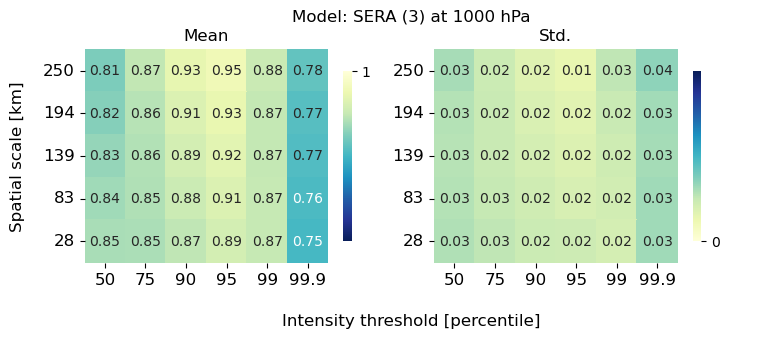

In [15]:
#intensity_scale_diagram(model='wmae_3_1000',title='Model: WMAE (5) at 1000 hPa')
#intensity_scale_diagram(model='wmse_4_1000',title='Model: WMSE (4) at 1000 hPa')
intensity_scale_diagram(model='sera_3_1000',title='Model: SERA (3) at 1000 hPa')
#intensity_scale_diagram(model='mae_3_1000',title='Model: MAE (5) at 1000 hPa')
#intensity_scale_diagram(model='mse_3_1000',title='Model: MSE (3) at 1000 hPa')


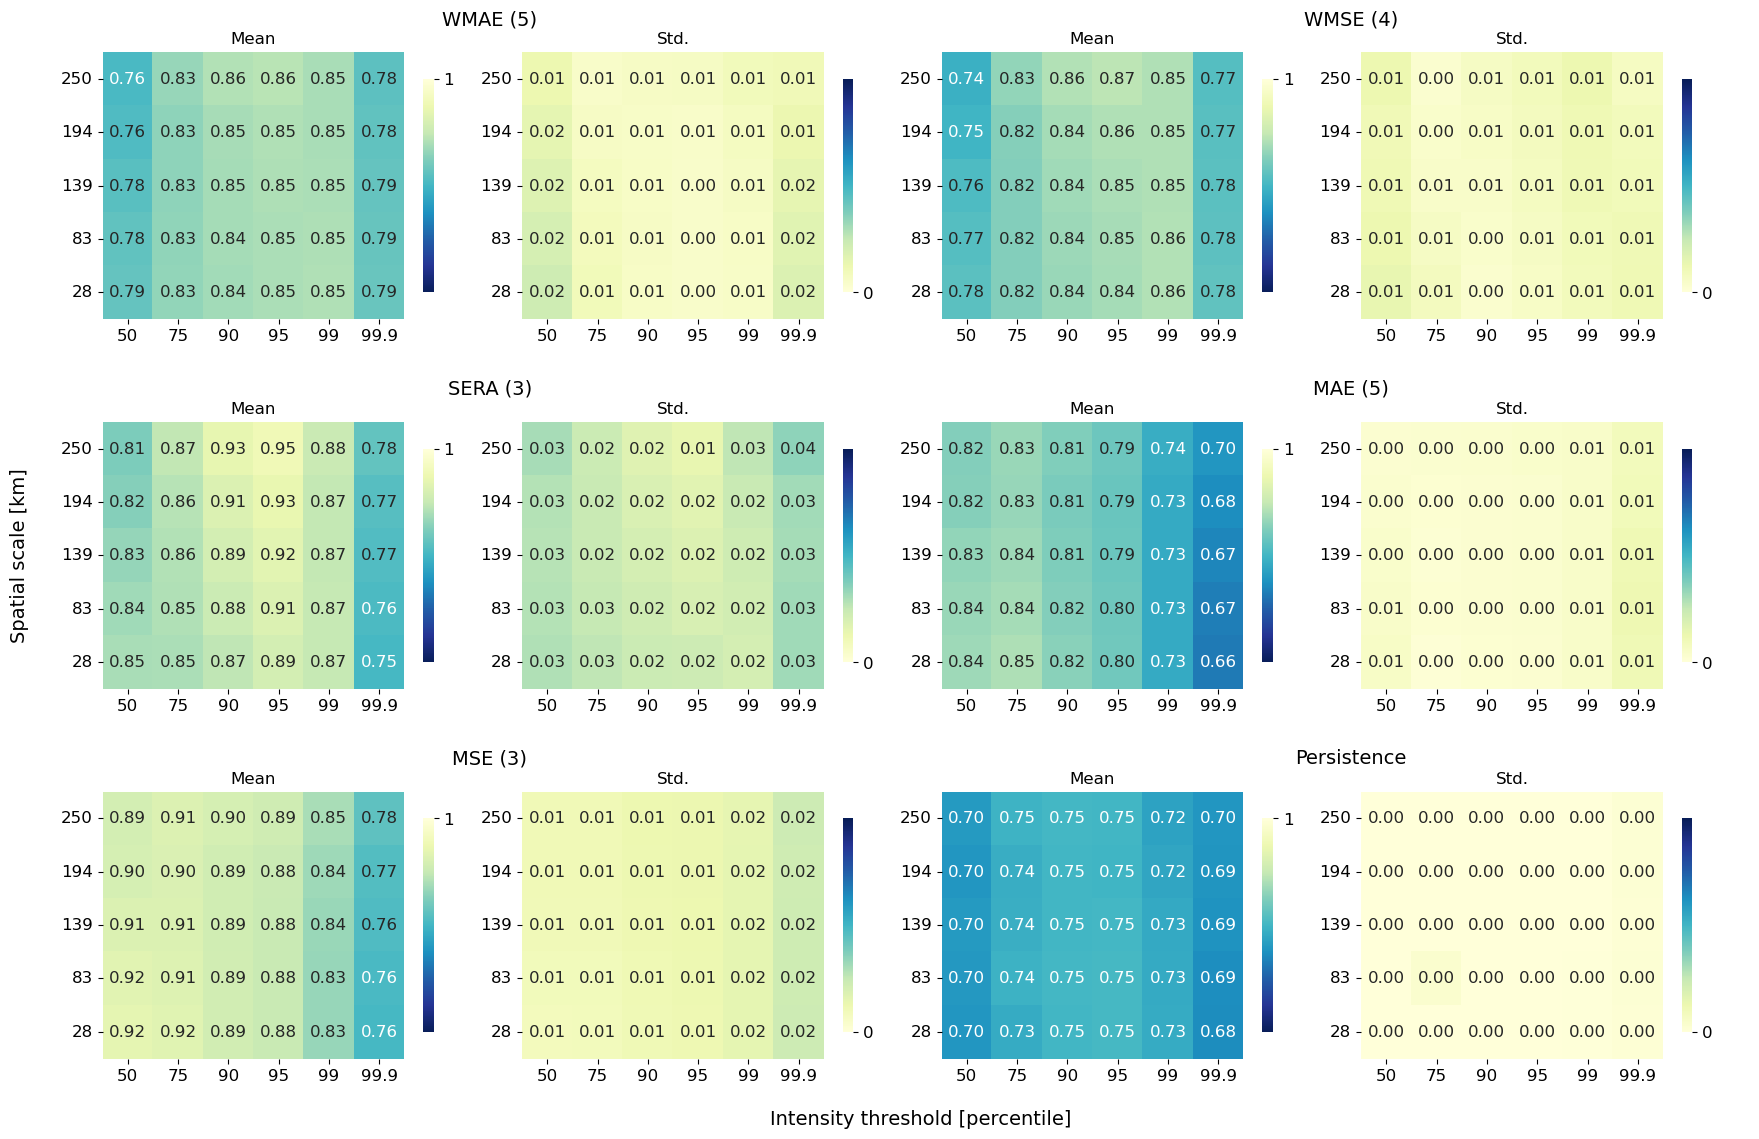

In [55]:
models = ['wmae_5','wmse_4','sera_3','mae_5','mse_3','persist']
model_names = ['WMAE (5)','WMSE (4)','SERA (3)','MAE (5)','MSE (3)','Persistence']

plt.style.use('default')

fig, axes = plt.subplots(3,4,figsize=(18, 12), sharex=True, sharey=True)

for i in range(6):
    ax=fig.add_subplot(3,2,i+1)
    ax.set_title(model_names[i], fontsize=14, pad=20)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

for i in range(3):
    for j in range(4):
        ax=axes[i,j]
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel('Spatial scale [km]',fontsize=14,labelpad=30)
plt.xlabel('Intensity threshold [percentile]',fontsize=14, labelpad=20)
#plt.title('SEDI for SERA_3',fontsize=12,pad=20)

thresholds = [50, 75, 90, 95, 99, 99.9]
scales = [int(i) for i in np.round(np.array([9,7,5,3,1])*111/4, 0)]

for m, model in enumerate(models):
    
    scores_splits = np.zeros((4,6,5))
    for j in range(4):
        scores_splits[j] = np.load(root + 'save_scores_random/%s_1000/scores_scales_extended_%s.npy'%(model,j))

    scores_splits = np.nan_to_num(scores_splits, nan=0.0)

    scores_scales = scores_splits.mean(0)
    stds_scales = scores_splits.std(0)
    
    for i, scores_ in enumerate([scores_scales, stds_scales]):
        axis_label = np.array(scales)
        df = pd.DataFrame(np.zeros((len(scales),len(thresholds))),index=scales, columns=thresholds, dtype=float)
        df = df.set_axis(axis_label, axis=0)
        for k, s in enumerate(scales): 
            df.iloc[k] = scores_[:,k]
        
        ax = fig.add_subplot(3,4,m*2+i+1)
        ax._frameon = False
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)

        # plot heatmap
        sb.heatmap(df, annot=True, fmt=".2f", cmap=['YlGnBu_r','YlGnBu'][i] ,
                   vmin=[0.5,0][i], vmax=[1,0.10][i], cbar_kws={"shrink": .8, "ticks":[0,1]}, annot_kws={"size":12})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)

        ax.set_title(['Mean','Std.'][i],fontsize=12)

        # ticks
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_yticklabels(axis_label, rotation=0, fontsize=12)
        ax.set_xticklabels(thresholds, fontsize=12)

plt.tight_layout()
plt.savefig(plot_root + 'intensity_tables_complete.png')
plt.show()


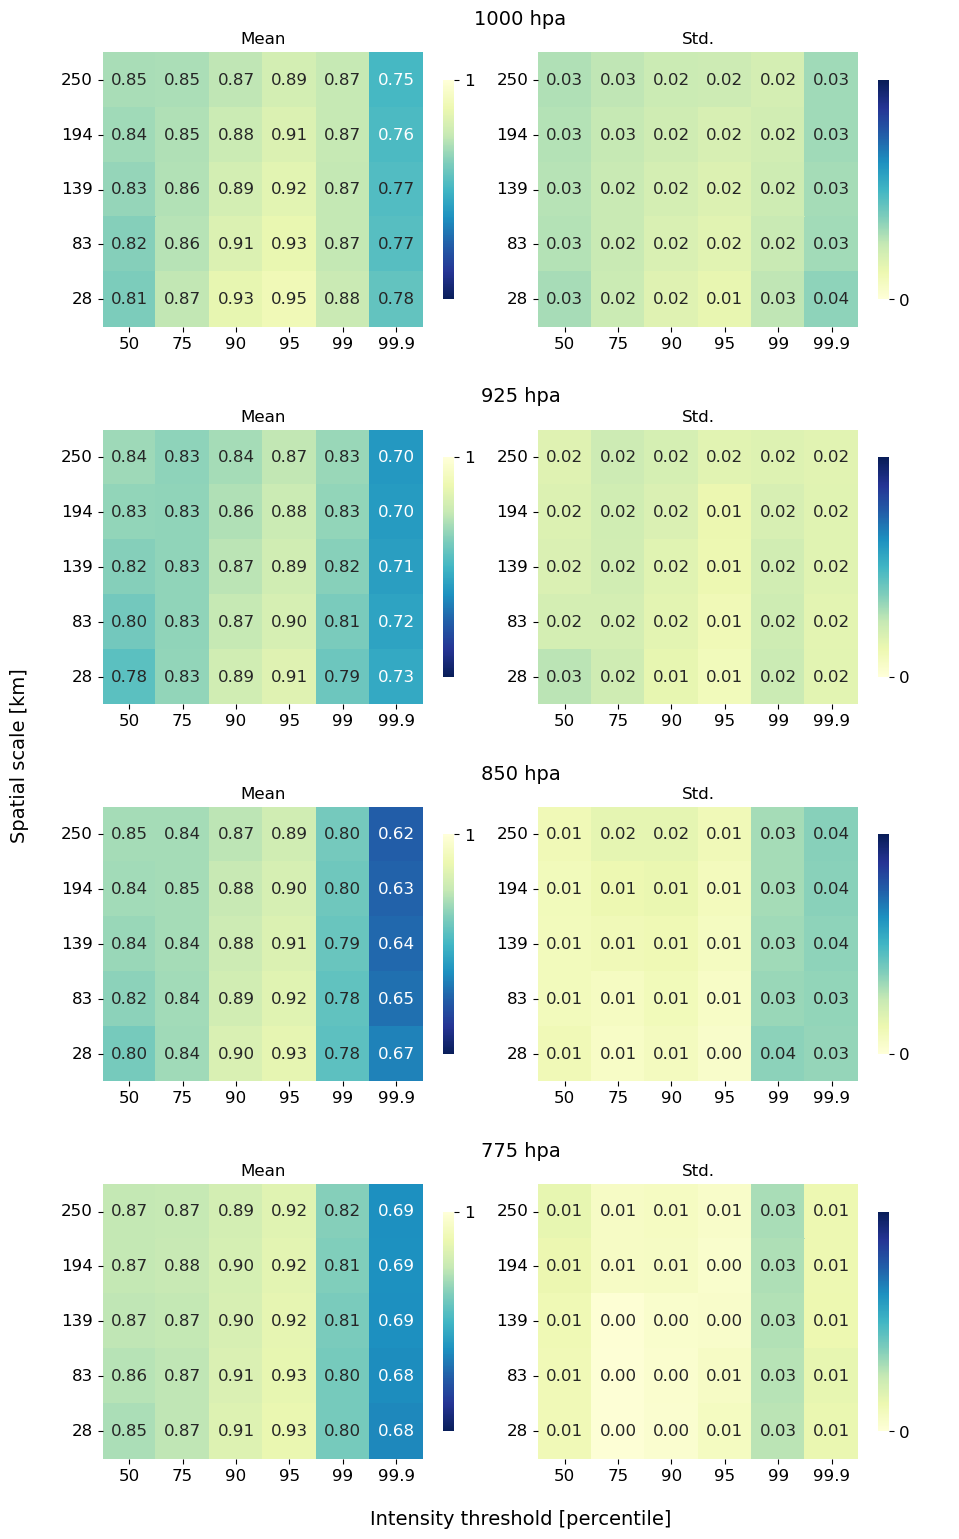

In [22]:
models = ['sera_3_1000','sera_3_925','sera_3_850','sera_3_775']
model_names = ['1000 hpa','925 hpa','850 hpa','775 hpa']

plt.style.use('default')

fig, axes = plt.subplots(4,2,figsize=(10, 16), sharex=True, sharey=True)

for i in range(4):
    ax=fig.add_subplot(4,1,i+1)
    ax.set_title(model_names[i], fontsize=14, pad=20)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

for i in range(4):
    for j in range(2):
        ax=axes[i,j]
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel('Spatial scale [km]',fontsize=14,labelpad=30)
plt.xlabel('Intensity threshold [percentile]',fontsize=14, labelpad=20)
#plt.title('SEDI for SERA_3',fontsize=12,pad=20)

thresholds = [50, 75, 90, 95, 99, 99.9]
scales = [int(i) for i in np.round(np.array([9,7,5,3,1])*111/4, 0)]

for m, model in enumerate(models):
    
    scores_splits = np.zeros((4,6,5))
    for j in range(4):
        scores_splits[j] = np.load(root + 'save_scores_random/%s/scores_scales_extended_%s.npy'%(model,j))

    scores_splits = np.nan_to_num(scores_splits, nan=0.0)

    scores_scales = scores_splits.mean(0)
    stds_scales = scores_splits.std(0)
    
    for i, scores_ in enumerate([scores_scales, stds_scales]):
        axis_label = np.array(scales)
        df = pd.DataFrame(np.zeros((len(scales),len(thresholds))),index=scales, columns=thresholds, dtype=float)
        df = df.set_axis(axis_label, axis=0)
        for k, s in enumerate(scales): 
            df.iloc[k] = np.flip(scores_, axis=1)[:,k]
        
        ax = fig.add_subplot(4,2,m*2+i+1)
        ax._frameon = False
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)

        # plot heatmap
        sb.heatmap(df, annot=True, fmt=".2f", cmap=['YlGnBu_r','YlGnBu'][i] ,
                   vmin=[0.5,0][i], vmax=[1,0.10][i], cbar_kws={"shrink": .8, "ticks":[0,1]}, annot_kws={"size":12})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)

        ax.set_title(['Mean','Std.'][i],fontsize=12)

        # ticks
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_yticklabels(axis_label, rotation=0, fontsize=12)
        ax.set_xticklabels(thresholds, fontsize=12)

plt.tight_layout()
plt.savefig(plot_root + 'intensity_tables_pressures.png')
plt.show()

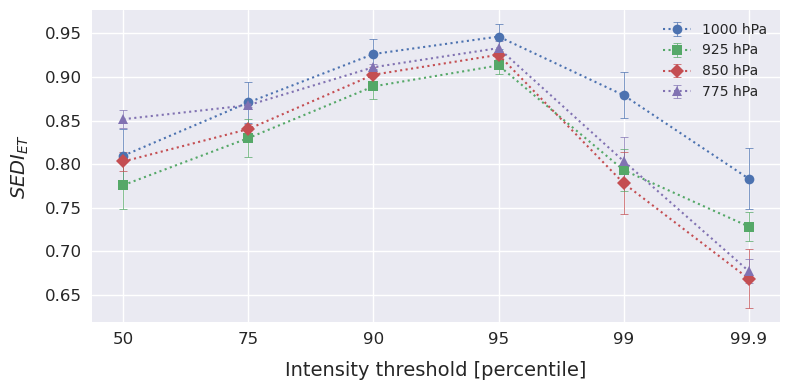

In [21]:
plt.style.use('seaborn')

models = ['sera_3_1000','sera_3_925','sera_3_850','sera_3_775']
model_names = ['1000 hPa','925 hPa','850 hPa','775 hPa']

markers = ['o','s','D','^']

scores_mean = []
scores_std = []

fig, ax = plt.subplots(figsize=(8,4))

ax.set_xlabel('Intensity threshold [percentile]',fontsize=14,labelpad=10)
ax.set_ylabel(r'$SEDI_{ET}$',fontsize=14,labelpad=10)


for i, model in enumerate(models):
    scores_splits = np.zeros((4,6,5))
    for j in range(4):
        scores_splits[j] = np.load(root + 'save_scores_random/%s/scores_scales_extended_%s.npy'%(model,j))

    scores_splits = np.nan_to_num(scores_splits, nan=0.0)

    means = scores_splits.mean(0)[:,0]
    stds = scores_splits.std(0)[:,0]
    
    ax.errorbar(['50','75','90','95','99','99.9'], means, yerr=stds, label=model_names[i], ls=':', marker=markers[i], linewidth=1.5, elinewidth=0.5, capsize=3, capthick=0.5)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc=1, fancybox=True,) #bbox_to_anchor=(1.35, 1.0))

plt.tight_layout()
#plt.savefig(plot_root + 'model_comparison_complete.png')
plt.show()

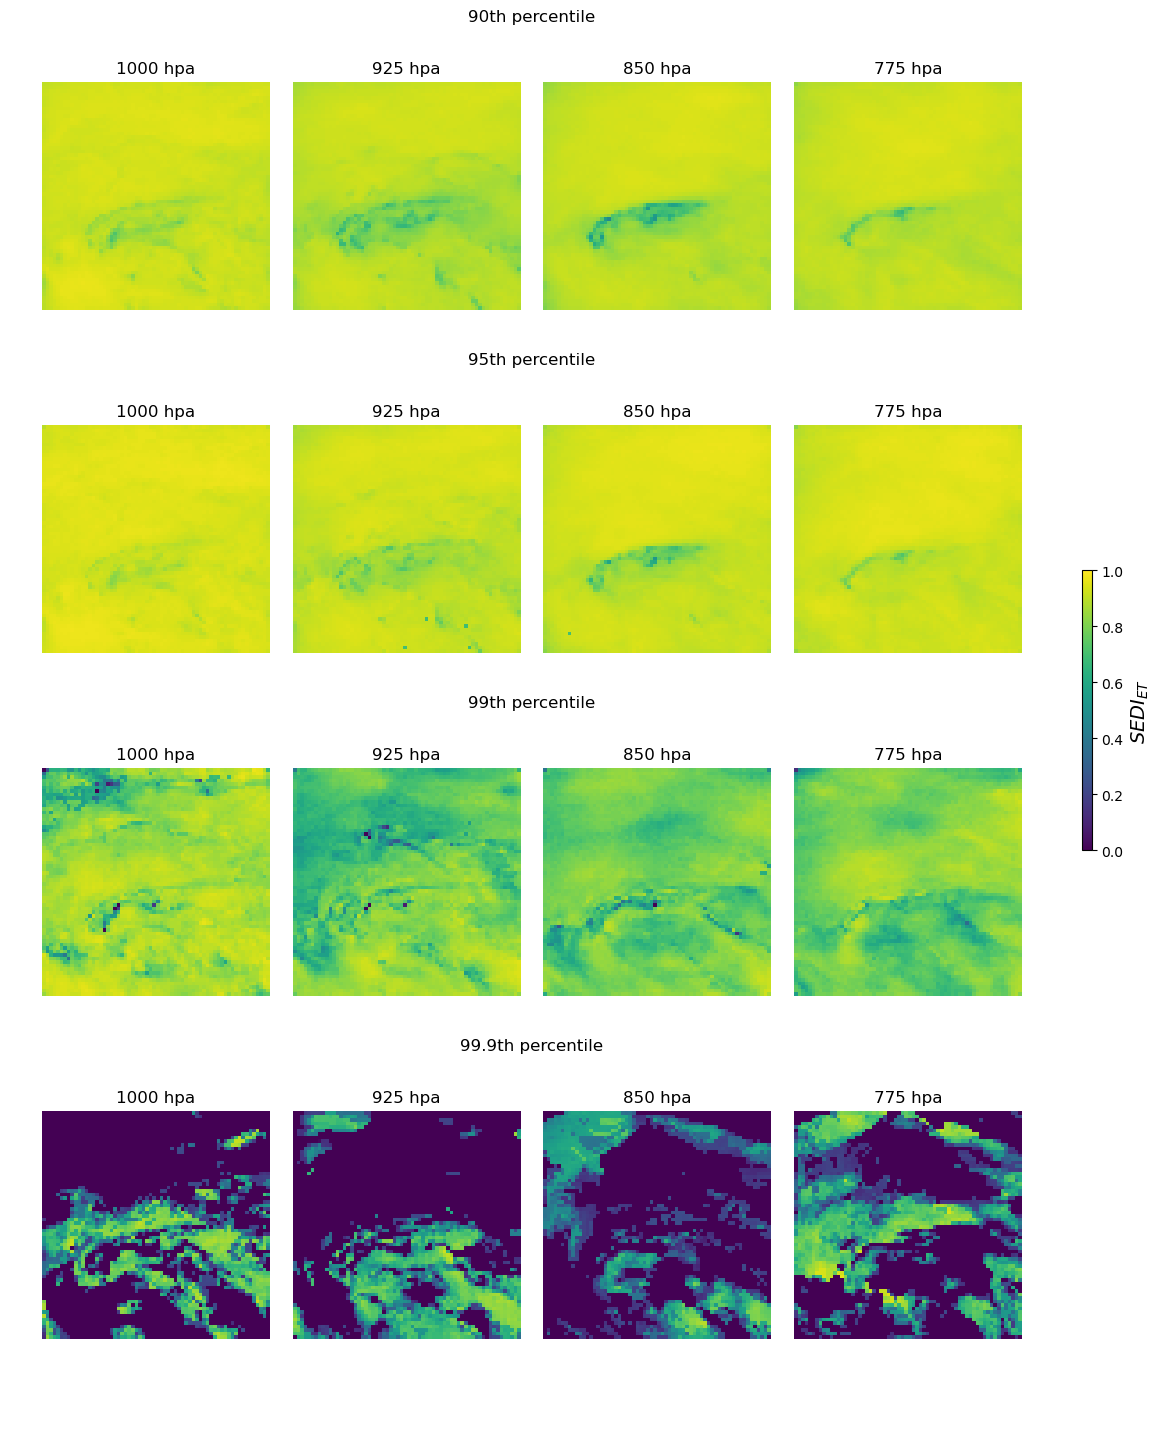

In [79]:
models = ['sera_3_1000','sera_3_925','sera_3_850','sera_3_775']
model_names = ['1000 hpa','925 hpa','850 hpa','775 hpa']

thresholds = [90, 95, 99, 99.9]
vmin, vmax = 0, 1
cmap = 'viridis'

plt.style.use('default')

fig, axes = plt.subplots(4,4,figsize=(10, 14), sharex=True, sharey=True)

for i in range(4):
    ax=fig.add_subplot(4,1,i+1)
    ax.set_title(['90th percentile', '95th percentile', '99th percentile','99.9th percentile'][i], fontsize=12, pad=-20)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

for i in range(4):
    for j in range(4):
        ax=axes[i,j]
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
#plt.ylabel('Spatial scale [km]',fontsize=14,labelpad=30)
#plt.xlabel('Intensity threshold [percentile]',fontsize=14, labelpad=20)
#plt.title('SEDI for SERA_3',fontsize=12,pad=20)



for i, threshold in enumerate(thresholds):
    for m, model in enumerate(models):

        scores_splits = np.zeros((4,64,64))
        for j in range(4):
            scores_splits[j] = np.load(root + 'save_scores_random/%s/scores_scales_coordinates_%s.npy'%(model,j))[i]

        scores_splits = np.nan_to_num(scores_splits, nan=0.0)

        scores = scores_splits.mean(0)
        stds = scores_splits.std(0)

        ax = fig.add_subplot(4,4,i*4+m+1)
        ax._frameon = False
        #ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im = ax.imshow(scores, cmap=cmap, vmin=vmin, vmax=vmax)    
        ax.set_title(model_names[m],fontsize=12)

        
cbar_ax = fig.add_axes([1.05, 0.4, 0.01, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$SEDI_{ET}$', fontsize=14, rotation=90)

plt.subplots_adjust(left=0.01,
                    bottom=0.01, 
                    right=0.99, 
                    top=0.99, 
                    wspace=0.1, 
                    hspace=0.)

#plt.tight_layout()
#plt.savefig(plot_root + 'intensity_tables_pressures.png')
plt.show()

In [24]:
def get_percentiles(data):
    l, r = data.min(), data.max()
    r = 8
    num=500
    
    n, bins = utils.function_hist(data, l, r, num)
    
    cs = np.cumsum(n)
    
    p1 = np.round(np.where(cs>0.01*sum(n))[0][0]*(r-l)/num+l, 1)
    p50 = np.round(np.where(cs>0.5*sum(n))[0][0]*(r-l)/num+l, 1)
    p75 = np.round(np.where(cs>0.75*sum(n))[0][0]*(r-l)/num+l, 1)
    p90 = np.round(np.where(cs>0.9*sum(n))[0][0]*(r-l)/num+l, 1)
    p95 = np.round(np.where(cs>0.95*sum(n))[0][0]*(r-l)/num+l, 1)
    p99 = np.round(np.where(cs>0.99*sum(n))[0][0]*(r-l)/num+l, 1)
    p999 = np.round(np.where(cs>0.999*sum(n))[0][0]*(r-l)/num+l, 1)
    
    return p90, p95, p99, p999

In [25]:
def get_data(hpa):
    data = np.load(data_root + 'adaptor.mars.internal-Horizontal_velocity_%s.npy'%hpa)[:24*365*8]
    data = utils.standardize_local(data)[0]
    percentiles = get_percentiles(data)
    return data, percentiles 

In [26]:
datasets, percentiles = [], []
for hpa in [1000, 925, 850, 775]: 
    d, p = get_data(hpa)
    datasets.append(d)
    percentiles.append(p)

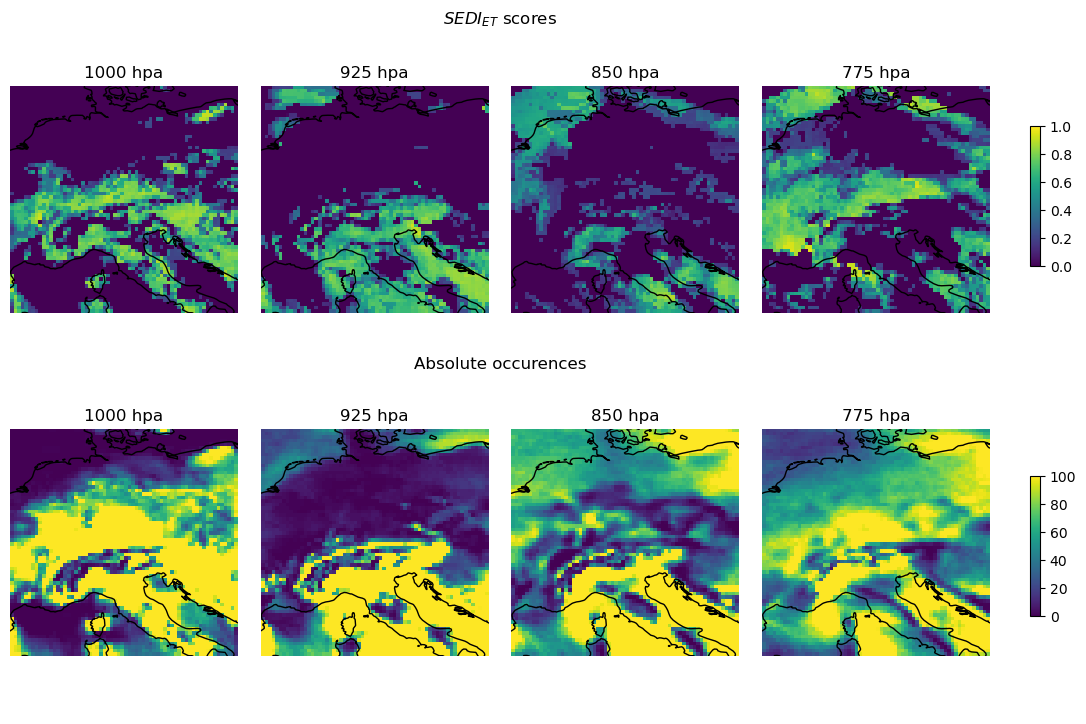

In [83]:

models = ['sera_3_1000','sera_3_925','sera_3_850','sera_3_775']
model_names = ['1000 hpa','925 hpa','850 hpa','775 hpa']

thresholds = [99, 99.9]
vmin, vmax = 0, 3
cmap = 'viridis'

plt.style.use('default')

central_lon, central_lat = 11, 48
extent = [3, 18.75,40, 55.75]

fig, axs = plt.subplots(2,4,figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()},)

flat=axs.flatten()

for i in range(8):
    #ax = plt.axes(projection=ccrs.Orthographic(central_lon, central_lat))
    flat[i].set_extent(extent)
    #axs[i].gridlines(alpha=0.8)
    flat[i].coastlines(resolution='50m')

for i in range(2):
    ax=fig.add_subplot(2,1,i+1)
    ax.set_title([r'$SEDI_{ET}$ scores','Absolute occurences'][i], fontsize=12, pad=-10)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

    
frames_scores = []
frames_occur = [] 
    
for i in range(2):
    for m, model in enumerate(models):
        if i == 0: 
            scores_splits = np.zeros((4,64,64))
            for j in range(4):
                scores_splits[j] = np.load(root + 'save_scores_random/%s/scores_scales_coordinates_%s.npy'%(model,j))[-1]

            scores_splits = np.nan_to_num(scores_splits, nan=0.0)

            scores = scores_splits.mean(0)
            #stds = scores_splits.std(0)
            frame = scores 
            frames_scores.append(frame)
            vmax=1
        if i == 1: 
            frame = (datasets[m]>percentiles[m][-1]).sum(0)
            frames_occur.append(frame)
            vmax=100

        ax = axs[i,m]
        ax._frameon = False
        #ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im = ax.imshow(frame, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, transform=ccrs.PlateCarree())    
        if m==3: 
            if i==0: 
                cbar_ax = fig.add_axes([1.03, 0.65, 0.01, 0.2])
                cbar = fig.colorbar(im, cax=cbar_ax)
                #cbar.set_label(r'$SEDI_{ET}$', fontsize=12, rotation=90)
            if i==1: 
                cbar_ax = fig.add_axes([1.03, 0.15, 0.01, 0.2])
                cbar = fig.colorbar(im, cax=cbar_ax)
                #cbar.set_label('Frequency', fontsize=12, rotation=90)
        ax.set_title(model_names[m],fontsize=12)

        

plt.subplots_adjust(left=0.01,
                    bottom=0.01, 
                    right=0.99, 
                    top=0.99, 
                    wspace=0.1, 
                    hspace=0.)
#plt.tight_layout()
#plt.savefig(plot_root + 'intensity_tables_pressures.png')
plt.show()

In [68]:
from sewar.full_ref import scc

for i in range(4):
    im1,im2 = frames_scores[i], frames_occur[i]
    print("SCC: ", np.round(scc(im1,im2),3))


SCC:  0.201
SCC:  0.176
SCC:  0.084
SCC:  0.032


In [6]:
def get_preds(hpa):

    STAMP = "sera_3_%s"%hpa
    data_root = '../../../../../../mnt/data/scheepensd94dm/data/'
    vis_root = '../../../../../../mnt/data/scheepensd94dm/data_visualization/'
    save_dir = '../../../../../../mnt/data/scheepensd94dm/save_model/%s/cv0/'%STAMP
    ani_root = '../../../../../../mnt/data/scheepensd94dm/animations/'

    class args():
        def __init__(self):
            self.frames_predict=12
            self.batch_size=16
            self.hpa=hpa
            self.num_layers=3

    args = args()
    
    encoder_params = convlstm_encoder_params(args.num_layers, args.frames_predict)
    decoder_params = convlstm_decoder_params(args.num_layers, args.frames_predict)
    encoder = Encoder(encoder_params[0], encoder_params[1]).cuda()
    decoder = Decoder(decoder_params[0], decoder_params[1], args.num_layers).cuda()
    net = ED(encoder, decoder)
    
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    print('==> loading existing model')
    model_info = torch.load(os.path.join(save_dir, 'checkpoint.pth.tar'))
    net.load_state_dict(model_info['state_dict'])
    net.eval()

    _, _, test_loader = load_era5(root=data_root, args=args, a=0.6, b=0.8, c=0.8)
    _, _, preds, _, _, _ = utils.predict_batchwise(test_loader, net, device, report=False)
    return preds

In [7]:
predictions = []
for hpa in [1000, 925, 850, 775]: 
    predictions.append(get_preds(hpa))

==> loading existing model
number of years: 10.0
percentiles: 1.4 2.8
==> loading existing model
number of years: 10.0
percentiles: 1.4 2.8
==> loading existing model
number of years: 10.0
percentiles: 1.4 3.0
==> loading existing model
number of years: 10.0
percentiles: 1.3 3.0


In [189]:
percentiles

[(1.3, 1.8, 2.8, 4.0),
 (1.4, 1.9, 2.8, 4.0),
 (1.4, 1.9, 3.0, 4.3),
 (1.3, 1.9, 3.0, 4.3)]

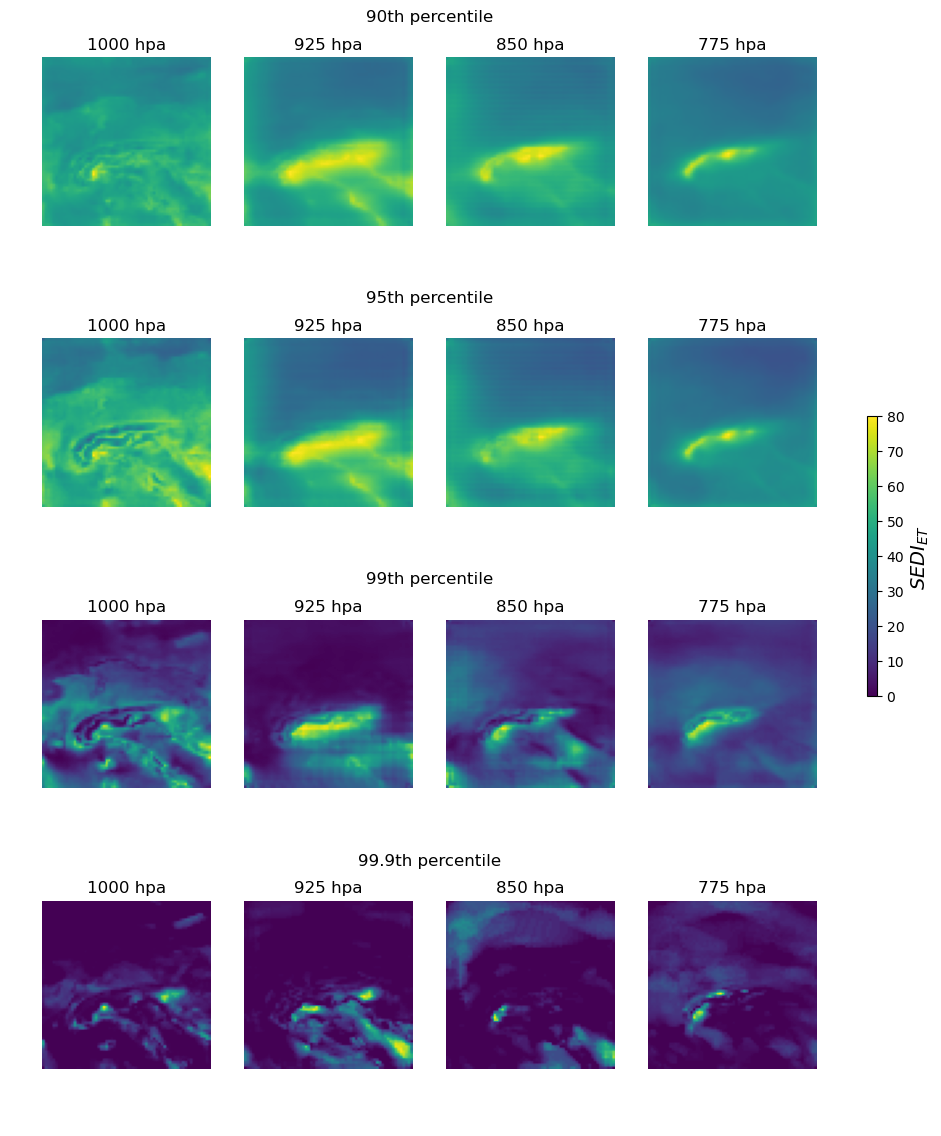

In [24]:
model_names = ['1000 hpa','925 hpa','850 hpa','775 hpa']

thresholds = [90, 95, 99, 99.9]
vmin, vmax = 0, 1
cmap = 'viridis'

plt.style.use('default')

fig, axes = plt.subplots(4,4,figsize=(10, 14), sharex=True, sharey=True)

for i in range(4):
    ax=fig.add_subplot(4,1,i+1)
    ax.set_title(['90th percentile', '95th percentile', '99th percentile','99.9th percentile'][i], fontsize=12, pad=0)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

for i in range(4):
    for j in range(4):
        ax=axes[i,j]
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
#plt.ylabel('Spatial scale [km]',fontsize=14,labelpad=30)
#plt.xlabel('Intensity threshold [percentile]',fontsize=14, labelpad=20)
#plt.title('SEDI for SERA_3',fontsize=12,pad=20)



for i, threshold in enumerate(thresholds):
    for m, model in enumerate(models):

        frame = (predictions[m]>percentiles[m][i]).sum((0,1))
        vmax=frame.max()
        vmin=0

        ax = fig.add_subplot(4,4,i*4+m+1)
        ax._frameon = False
        #ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im = ax.imshow(frame, cmap=cmap, vmin=vmin, vmax=vmax)    
        ax.set_title(model_names[m],fontsize=12)

        
cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$SEDI_{ET}$', fontsize=14, rotation=90)

#plt.tight_layout()
#plt.savefig(plot_root + 'intensity_tables_pressures.png')
plt.show()

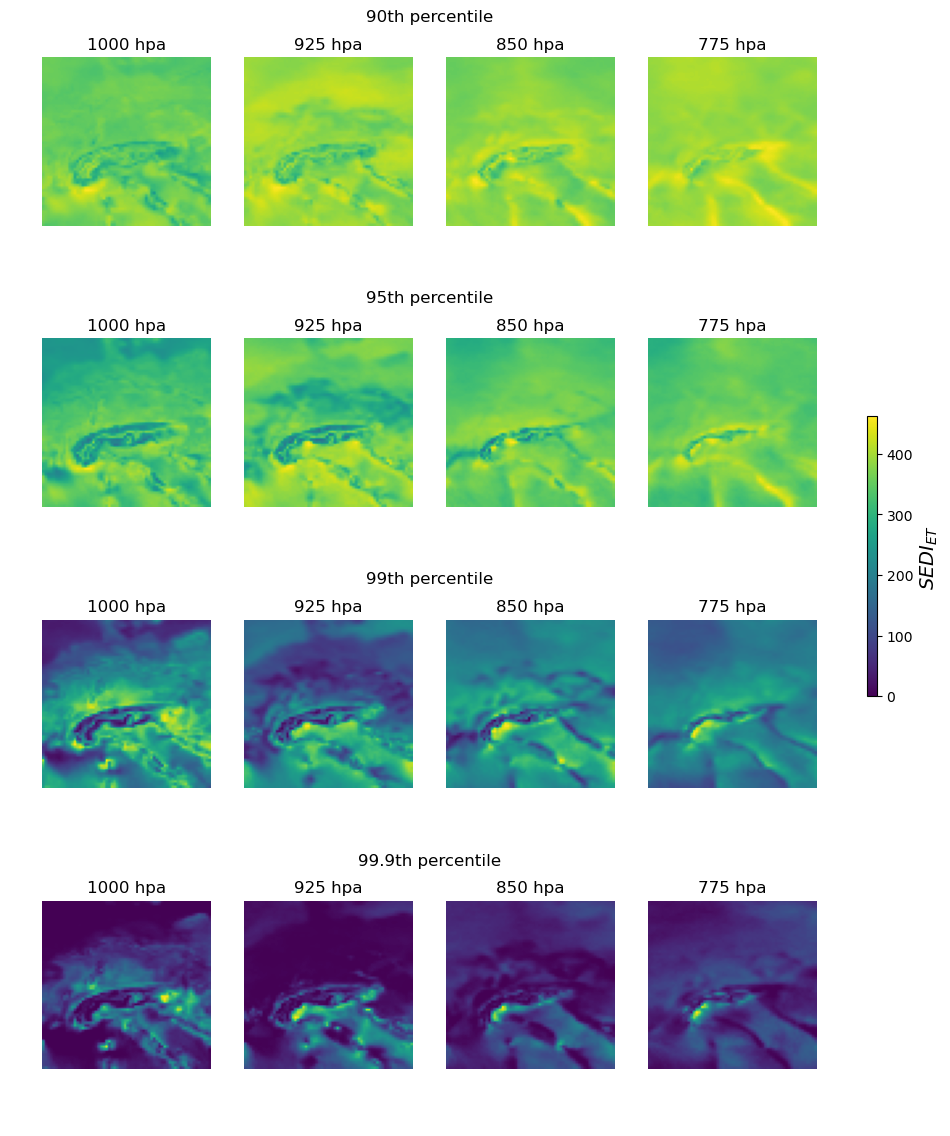

In [25]:
model_names = ['1000 hpa','925 hpa','850 hpa','775 hpa']

thresholds = [90, 95, 99, 99.9]
vmin, vmax = 0, 1
cmap = 'viridis'

plt.style.use('default')

fig, axes = plt.subplots(4,4,figsize=(10, 14), sharex=True, sharey=True)

for i in range(4):
    ax=fig.add_subplot(4,1,i+1)
    ax.set_title(['90th percentile', '95th percentile', '99th percentile','99.9th percentile'][i], fontsize=12, pad=0)
    ax._frameon = False
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

for i in range(4):
    for j in range(4):
        ax=axes[i,j]
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
#plt.ylabel('Spatial scale [km]',fontsize=14,labelpad=30)
#plt.xlabel('Intensity threshold [percentile]',fontsize=14, labelpad=20)
#plt.title('SEDI for SERA_3',fontsize=12,pad=20)



for i, threshold in enumerate(thresholds):
    for m, model in enumerate(models):

        frame = (datasets[m]>percentiles[m][i]).sum(0)
        vmax=frame.max()
        vmin=0

        ax = fig.add_subplot(4,4,i*4+m+1)
        ax._frameon = False
        #ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im = ax.imshow(frame, cmap=cmap, vmin=vmin, vmax=vmax)    
        ax.set_title(model_names[m],fontsize=12)

        
cbar_ax = fig.add_axes([0.95, 0.4, 0.01, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$SEDI_{ET}$', fontsize=14, rotation=90)

#plt.tight_layout()
#plt.savefig(plot_root + 'intensity_tables_pressures.png')
plt.show()

## Times 

In [642]:
scores_splits = np.zeros((4,4,8,8))
scores_splits[0] = pickle.load(open(data_root + "saved_scores/scores_scales_cnn_regr62_test_thresholds.p",'rb'))
for j in range(1,4):
    scores_splits[j] = pickle.load(open(data_root + 'saved_scores/scores_scales_cnn_regr62_%s_test_thresholds.p'%j,'rb'))

scores_scales = np.transpose(scores_splits.mean(0),[1,0,2])
stds_scales = np.transpose(scores_splits.std(0),[1,0,2])

In [643]:
scores_splits = np.zeros((4,4,8,8,12))
scores_splits[0] = pickle.load(open(data_root + "saved_scores/scores_times_cnn_regr62_test_thresholds.p",'rb'))
for j in range(1,4):
    scores_splits[j] = pickle.load(open(data_root + 'saved_scores/scores_times_cnn_regr62_%s_test_thresholds.p'%j,'rb'))

scores_times = np.transpose(scores_splits.mean(0),[1,0,2,3])
stds_times = np.transpose(scores_splits.std(0),[1,0,2,3])

In [644]:
#random = np.array([11.86827, 3.26543, 0.62154, 0.09802, 0.01535])/100
random = [0.10,0.05,0.01,0.001]
scales = [(15,15),(13,13),(11,11),(9,9),(7,7),(5,5),(3,3),(1,1)]
thresholds = [1.2, 1.8, 2.7, 4.0]

In [999]:
null_scales = pickle.load(open(data_root+"saved_scores/scores_scales_NULL_test_thresholds.p",'rb'))
null_times = pickle.load(open(data_root+"saved_scores/scores_times_NULL_test_thresholds.p",'rb'))

In [1001]:
null_scales.shape

(4, 7)

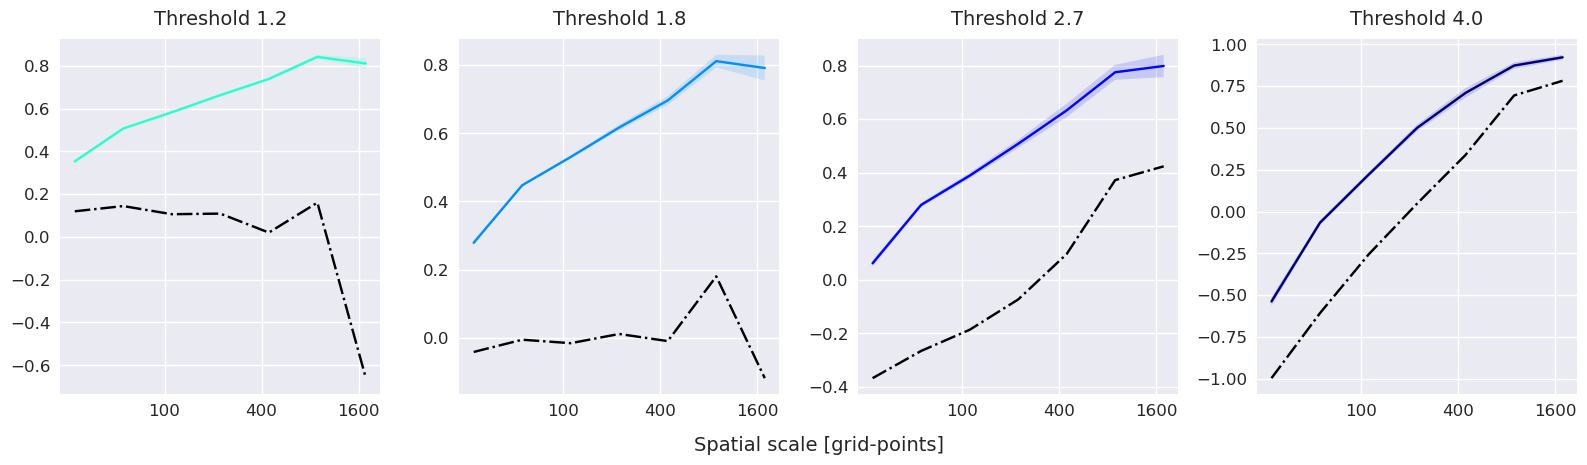

In [1024]:
#plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn')

fig, axes = plt.subplots(1,1,figsize=(16,5))

axes.set_xlabel('Spatial scale [grid-points]', fontsize=14, labelpad=30)

axes._frameon = False
axes.get_xaxis().set_ticks([])
axes.get_yaxis().set_ticks([])
axes.get_xaxis().set_ticklabels([])
axes.get_yaxis().set_ticklabels([])

col = matplotlib.cm.get_cmap('jet_r')(np.linspace(0.6,1,4)) 

for j, threshold in enumerate([1.2, 1.8, 2.7, 4.0]):

    ax = fig.add_subplot(1,4,j+1)
    
    xvals = np.array([1,2,4,8,16,32,64])*111/4
    values = np.flip(scores_scales[-1,j,:-1])
    stds = np.flip(stds_scales[-1,j,:-1])
    ax.set_xscale('log')
    ax.set_xticks([100,400,1600])
    ax.set_xticklabels([100,400,1600]) 
    ax.set_title('Threshold %s'%threshold, fontsize=14, pad=10)
    

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.plot(xvals, values, label='Threshold: %s'%threshold, color=col[j])
    ax.fill_between(xvals, values-stds, values+stds, alpha=0.15, facecolor=col[j], linewidth=1)
    
    null_values = np.flip(null_scales[j])
    ax.plot(xvals, null_values, label='Null model', ls='-.',color='black')
    
    #if j==3:
    #    legend=ax.legend(loc=1, bbox_to_anchor=(1.36, 1.0), fontsize=12, fancybox=True)
#legend.get_title().set_fontsize('12')


plt.tight_layout()
plt.savefig(data_root + 'IS_null_model.png')
plt.show()

In [512]:
def intensity_scale_diagrams(MC, FSS, IS, save_as):
    plt.style.use('default')
    
    fig, axes = plt.subplots(figsize=(16, 8))
    axes._frameon = False
    #axes.get_xaxis().set_visible(False)
    #axes.get_yaxis().set_visible(False)
    axes.get_xaxis().set_ticks([])
    axes.get_yaxis().set_ticks([])
    axes.get_xaxis().set_ticklabels([])
    axes.get_yaxis().set_ticklabels([])
    axes.set_xlabel('Intensity threshold [σ]',fontsize=14,labelpad=40)
    axes.set_ylabel('Spatial scale [grid-points]',fontsize=14,labelpad=40)
    
    thresholds = [1.2, 1.8, 2.7, 4.0]
    
    for i, title in enumerate(['SEDI','PSS','CSS','Recall','Precision','F1','FSS','IS']): 
        
        
        if i==7:
            scales = [(64,64),(32,32),(16,16),(8,8),(4,4),(2,2),(1,1)]            
        else: 
            scales = [(15,15),(13,13),(11,11),(9,9),(7,7),(5,5),(3,3),(1,1)]
        
        axis_label = np.array(scales)[:,0]
        df = pd.DataFrame(np.zeros((len(scales),len(thresholds))),index=scales, columns=thresholds, dtype=float)
        df = df.set_axis(axis_label, axis=0)
        for k, s in enumerate(scales): 
            if i==6:
                df.iloc[k] = FSS[:,k]
            elif i==7:
                df.iloc[k] = IS[:,k]
            else: 
                df.iloc[k] = MC[i,:,k]

        ax = fig.add_subplot(2,4,i+1)
        ax._frameon = True
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)
        
        # plot heatmap
        sb.heatmap(df, annot=True, fmt=".2f", cmap='RdYlGn' ,
                   vmin=0, vmax=1, cbar_kws={"shrink": .8, "ticks":[0,1]})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        
        #else: 
        #    sb.heatmap(df, annot=True, fmt=".2f", cmap='RdYlGn' ,
        #               vmin=0, vmax=1, cbar=None)
        
        
        
        ax.set_title(title,fontsize=12)
        
        # ticks
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_yticklabels(axis_label, rotation=0, fontsize=12)
        if i>=4:
            ax.set_xticklabels(thresholds, fontsize=12)
        else:
            ax.set_xticklabels([])
        #if i!=0:
        #    ax.get_yaxis().set_visible(False)
        
    plt.tight_layout()
    plt.savefig(data_root + save_as)
    plt.show()

    return 

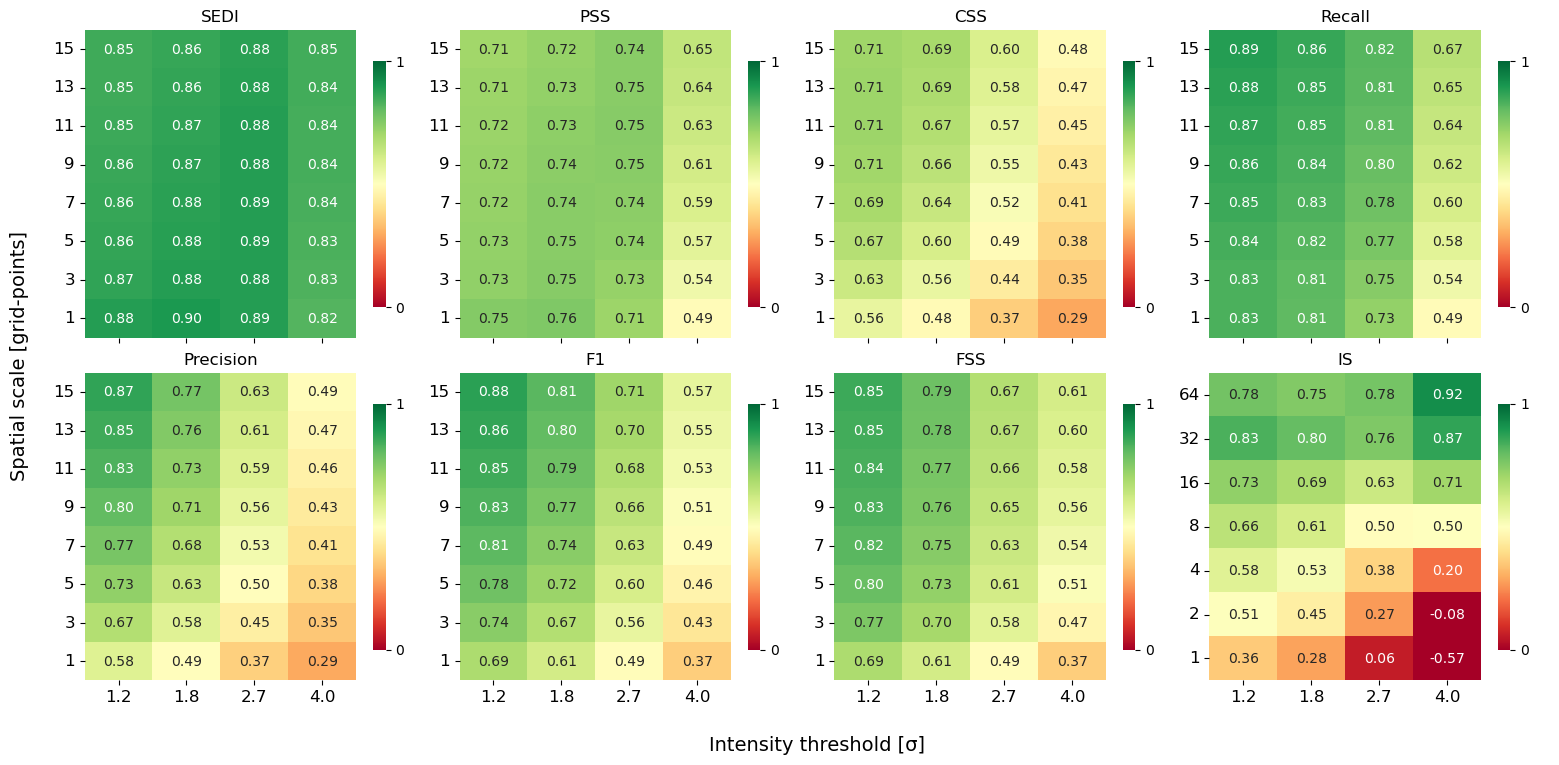

In [513]:
intensity_scale_diagrams(MC_S, FSS_S, IS_S, save_as='big_fig_spatial.png')

In [342]:
def plot_fss_leadtimes(scores, random, thresholds, scales, args, plot_random=False):
            
    km_scales = [s[0]*111/4 for s in scales]
    km_scales_rounded = [int(np.round(s,-1)) for s in km_scales]

    fig, axes = plt.subplots(figsize=(15,7),nrows=1, ncols=4, sharex=True, sharey=True)
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Lead-time [h]", fontsize=14,labelpad=10)
    
    #col = matplotlib.cm.get_cmap('hsv_r')(np.linspace(0.5,1.,len(scales))) 
    col = matplotlib.cm.get_cmap('jet')(np.linspace(0.3,1.,len(scales))) 
    
    
    for i, threshold in enumerate(thresholds):
            
        ax = axes[i]
        #ax.axvline(x=8,ls='--',c='grey')
        if plot_random:
            ax.axhline(random[i],ls='--',c='black')
            ax.text(x=1.2,y=random[i]+0.015,s='random')
            ax.axhline((1+random[i])/2,ls='--',c='black')
            ax.text(x=1.2,y=(1+random[i])/2+0.015,s='target')
        ax.set_ylim(0,1)
        ax.set_xlim(1,12)
        ax.set_xticks(np.arange(2,args.frames_predict+1,2))
        ax.grid(True,axis='both')
        ax.set_title('Threshold=%s'%threshold, fontsize=12)
        for j, scale in enumerate(scales): 
            ax.plot(np.arange(1,args.frames_predict+1), scores[i,j], label=km_scales_rounded[j], c=col[j], alpha=0.6)            
            #ax.plot(np.arange(1, args.frames_predict+1), scores[i][j], label=km_scales_rounded[j], c=col[j], alpha=0.5)
            #error = fss_std/2
            #ax.fill_between(np.arange(1, len(fss_mean)+1), fss_mean-error, fss_mean+error,
            #    alpha=0.2, facecolor=col[j],
            #    linewidth=0)
        if i==3:
            legend=ax.legend(loc='upper right',title="Scale [km]",fontsize=12,bbox_to_anchor=(1.45, 1.01))  
            legend.get_title().set_fontsize('12') #legend 'Title' fontsize
            
        
        
    plt.tight_layout()
    plt.show()

In [875]:
def plot_fss_scales(scores_times, scores_scales, stds_times, stds_scales, thresholds, scales, args, random=None, save_as=None):
    plt.style.use('default')
    
    km_scales = [s[0]*111/4 for s in scales]
    km_scales_rounded = [int(np.round(s,-1)) for s in km_scales]
    alpha=0.6

    fig, axes = plt.subplots(figsize=(15,8),nrows=1, ncols=4, sharex=True, sharey=True)
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Spatial scale [km]", fontsize=14,labelpad=10)
    #plt.suptitle("FSS",fontsize=14)
    
    #col = matplotlib.cm.get_cmap('hsv_r')(np.linspace(0.5,1.,len(scales))) 
    #col = matplotlib.cm.get_cmap('jet')(np.linspace(0.3,1.,len(scales))) 
    col = matplotlib.cm.get_cmap('jet_r')(np.linspace(0.5,1.,12)) 
    
    def get_x_intercept(x0,x1,y0,y1,h):
        a = (y1-y0)/(x1-x0)
        b = y0 - a*x0
        return (h-b)/a
    
    def get_all_intercepts(scores, random, thresholds, km_scales):
        intercepts = [[] for i in range(len(thresholds))]
        for i, threshold in enumerate(thresholds):
            target_line = (1+random[i])/2
            for j, time in enumerate(np.arange(0,scores.shape[-1],1)):  
                curve = scores[i,:,time]
                if curve.max()>=target_line and curve.min()<=target_line: # i.e. intersection possible
                    indices = np.where(curve>=target_line)[0]
                    x1, y1 = km_scales[indices.max()], curve[indices.max()]
                    x0, y0 = km_scales[indices.max()+1], curve[indices.max()+1] # scales go in reverse order
                    x = get_x_intercept(x0,x1,y0,y1,target_line)
                    intercepts[i].append([j,x])
                elif curve.max()>=target_line and curve.min()>=target_line:
                    intercepts[i].append([j,km_scales[-1]])
                else:
                    intercepts[i].append([j,np.NaN])
        return intercepts         
    
    intercepts = get_all_intercepts(scores_times, random, thresholds, km_scales)
    
    intercepts_left = get_all_intercepts(scores_times+stds_times, random, thresholds, km_scales)
    intercepts_right = get_all_intercepts(scores_times-stds_times, random, thresholds, km_scales)
    
    for i in range(4):
        for j, x in intercepts[i]:
            if x==km_scales[-1]: 
                intercepts_left[i][j][1]=km_scales[-1]
                intercepts_right[i][j][1]=km_scales[-1]
            elif np.isnan(x):
                intercepts_left[i][j][1]=np.NaN
                intercepts_right[i][j][1]=np.NaN
            if np.isnan(intercepts_right[i][j][1]): 
                if np.isnan(intercepts_left[i][j][1])==False and np.isnan(intercepts[i][j][1])==False: 
                    #intercepts_right[i][j][1]=2*intercepts[i][j][1] - intercepts_left[i][j][1]
                    intercepts_left[i][j][1]=np.NaN
                    intercepts[i][j][1]=np.NaN
                
    for i, threshold in enumerate(thresholds):
        
        ax = axes[i]
        #ax.axvline(x=8,ls='--',c='grey')
        ax.axhline(random[i],ls='--',c='black')
        ax.text(x=320,y=random[i]+0.015,s='random',fontsize=12)
        ax.axhline((1+random[i])/2,ls='--',c='black')
        ax.text(x=340,y=(1+random[i])/2+0.015,s='target',fontsize=12)
        #ax.set_ylim(-0.5,0.5)
        ax.set_xlim(27.75,416.25)
        #ax.set_xticks(np.arange(2,args.frames_predict+1,2))
        ax.grid(True,axis='both')
        ax.set_title('Threshold %s'%threshold, fontsize=14, pad=10)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        #for j, scale in enumerate(scales): 
        for j, time in enumerate(np.arange(0,args.frames_predict,1)):    
            ax.plot(km_scales, scores_times[i,:,time], label=time+1, c=col[j], alpha=alpha,zorder=1)            
            #ax.plot(np.arange(1, args.frames_predict+1), scores[i][j], label=km_scales_rounded[j], c=col[j], alpha=0.5)
            #error = fss_std/2
            ax.fill_between(km_scales, scores_times[i,:,time]-stds_times[i,:,time], scores_times[i,:,time]+stds_times[i,:,time],alpha=0.15, facecolor=col[j],linewidth=1)
        ax.errorbar(km_scales,scores_scales[i],stds_scales[i],label='Overall',ls='-.',c='black',elinewidth=0.5, capsize=3,capthick=0.5)

        if i==3:
            legend=ax.legend(loc='upper right',title="Lead-time [h]",fontsize=12,bbox_to_anchor=(1.55, 1.0))  
            legend.get_title().set_fontsize('12') #legend 'Title' fontsize
        
        for l,m,r in zip(intercepts_left[i], intercepts[i], intercepts_right[i]): 
            ax.axvline(x=l[1],ls='-',c=col[l[0]],ymax=(1+random[i])/2,alpha=0.15)
            #ax.axvline(x=x,ls='--',c=col[j],ymax=(1+random[i])/2,alpha=alpha)
            ax.axvline(x=r[1],ls='-',c=col[l[0]],ymax=(1+random[i])/2,alpha=0.15)
            ax.axvspan(l[1], r[1], color=col[l[0]], ymax=(1+random[i])/2, alpha=0.15)
        
            
    plt.tight_layout()
    plt.savefig(data_root + save_as)
    plt.show()
    
    return intercepts, intercepts_left, intercepts_right

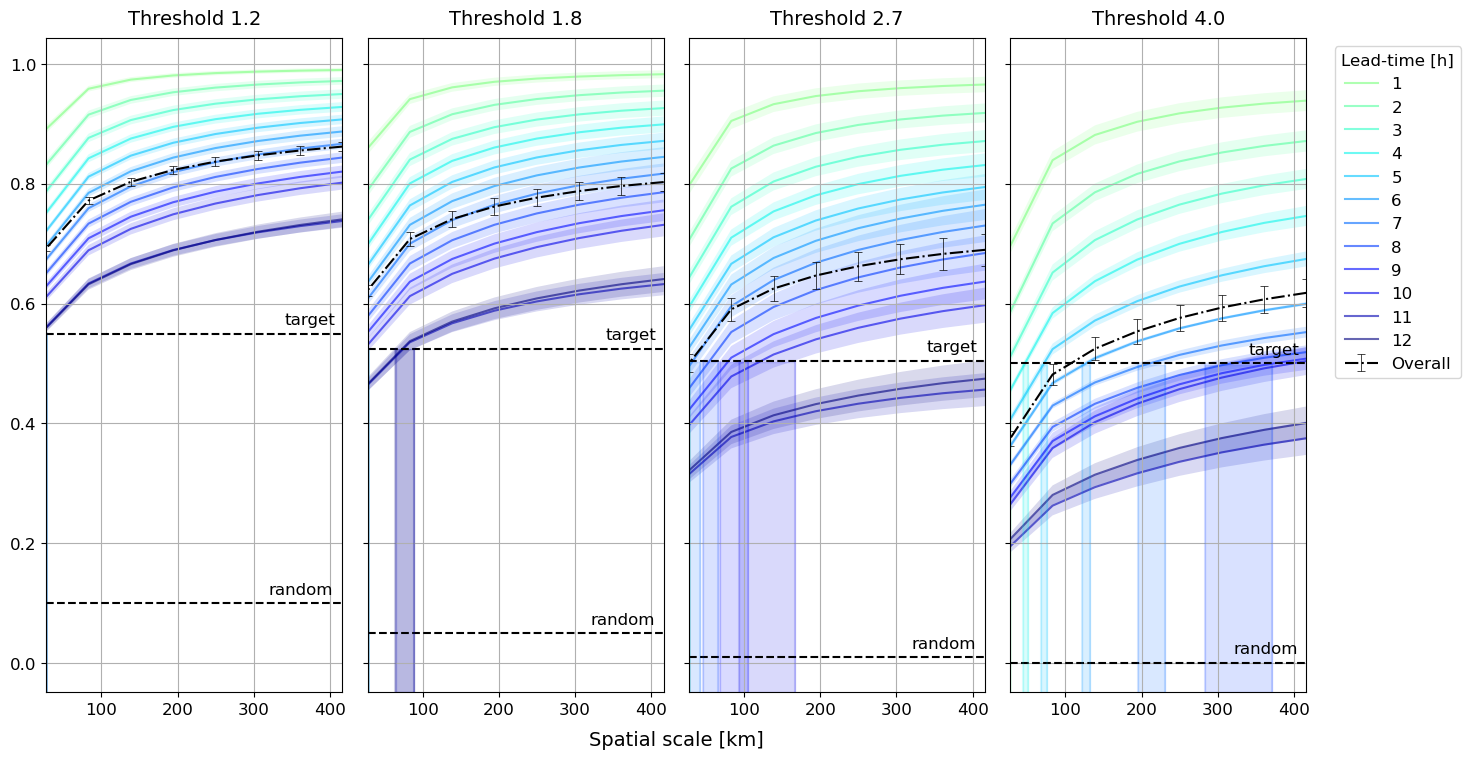

In [876]:
#plot_fss_leadtimes(FSS_T, random, thresholds, scales, args, plot_random=True)
intercepts, intercepts_left, intercepts_right = plot_fss_scales(scores_times[6], scores_scales[6], stds_times[6], stds_scales[6], thresholds, scales, args, random, save_as='fss_scores.png')
#plot_fss_scales(FSS_T_persist, FSS_S_persist, random, thresholds, scales, args, plot_random=True, title='FSS')

In [884]:
intercepts_left[3]

[[0, 27.75],
 [1, 27.75],
 [2, 27.75],
 [3, 44.08093581724677],
 [4, 68.04625838087291],
 [5, 122.37045880833446],
 [6, 194.6945212493185],
 [7, 283.29844824189985],
 [8, nan],
 [9, nan],
 [10, nan],
 [11, nan]]

In [885]:
intercepts[3]

[[0, 27.75],
 [1, 27.75],
 [2, 27.75],
 [3, 47.15777634415046],
 [4, 72.13181250798439],
 [5, 127.56021984658095],
 [6, 211.71438037127393],
 [7, 320.04165626947884],
 [8, nan],
 [9, nan],
 [10, nan],
 [11, nan]]

In [886]:
intercepts_right[3]

[[0, 27.75],
 [1, 27.75],
 [2, 27.75],
 [3, 50.391307753978275],
 [4, 76.35190839213344],
 [5, 132.5479873561494],
 [6, 230.87775814842072],
 [7, 370.5153396723749],
 [8, nan],
 [9, nan],
 [10, nan],
 [11, nan]]

In [899]:
def plot_scores_scales_together(scores_times, scores_scales, stds_times, stds_scales, thresholds, args, intercepts_left, intercepts_right, random, save_as=None):
    
    score_names = ['SEDI','PSS','CSS','FSS','ISS']
    alpha=0.8
    
    fig, axes = plt.subplots(figsize=(16,18),nrows=5, ncols=1, sharex=False, sharey=False)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Spatial scale [km]", fontsize=14,labelpad=10)
    #plt.suptitle(title,fontsize=14)
    
    for i, ax in enumerate(axes):
        #ax.set_title(score_names[i], fontsize=14)
        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        #big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        # removes the white frame
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])
        ax.set_ylabel(score_names[i],fontsize=14, labelpad=50)
    

    #col = matplotlib.cm.get_cmap('hsv_r')(np.linspace(0.5,1.,len(scales))) 
    #col = matplotlib.cm.get_cmap('jet')(np.linspace(0.3,1.,len(scales))) 
    col = matplotlib.cm.get_cmap('jet_r')(np.linspace(0.,1.,12)) 
    count=-1
    
    def get_y_intercept(x0,x1,y0,y1,v):
        a = (y1-y0)/(x1-x0)
        b = y0 - a*x0
        return a*v+b
    
    def get_score_intercepts(scores, intercepts, thresholds, km_scales):
        scores_intercepts = np.empty((len(thresholds),scores.shape[-1]))
        scores_intercepts[:,:] = np.NaN
        for i, threshold in enumerate(thresholds):
            for j, time in enumerate(np.arange(0,scores.shape[-1],1)):  
                curve = scores[i,:,j]
                for k, x in intercepts[i]:
                    if j==k: 
                        if x==27.75: 
                            scores_intercepts[i,j] = curve[-1]
                        elif np.isnan(x):
                            continue
                        else:
                            indx = np.where(km_scales == km_scales[km_scales>=x][-1])[0][0] # index of smallest scale larger than x
                            y0 = curve[indx]#[km_scales>=x][-1]
                            y1 = curve[indx+1]#[km_scales>=x][-2]
                            x0 = km_scales[np.where(curve==y0)[0][0]]
                            x1 = km_scales[np.where(curve==y1)[0][0]]
                            y = get_y_intercept(x0,x1,y0,y1,x)
                            scores_intercepts[i,j] = y
        return scores_intercepts
    
    intercepts_top = np.zeros((5,len(thresholds),scores_times.shape[-1]))
    intercepts_bot = np.zeros((5,len(thresholds),scores_times.shape[-1]))
    
    for l, s in enumerate([0,1,2,6,7]):
        count+=1
        if s==7: 
            scales = [(64,64),(32,32),(16,16),(8,8),(4,4),(2,2),(1,1)]
        else: 
            scales = [(15,15),(13,13),(11,11),(9,9),(7,7),(5,5),(3,3),(1,1)]
        
        km_scales = np.array([s[0]*111/4 for s in scales])
        km_scales_rounded = np.array([int(np.round(s,-1)) for s in km_scales])
        
        
        scores_intercepts_top = get_score_intercepts(scores_times[s]+stds_times[l], intercepts_right, thresholds, km_scales) 
        scores_intercepts_bot = get_score_intercepts(scores_times[s]-stds_times[l], intercepts_left, thresholds, km_scales) 
        intercepts_top[l] = scores_intercepts_top
        intercepts_bot[l] = scores_intercepts_bot
        
        for i, threshold in enumerate(thresholds):
            
            ax = fig.add_subplot(5,4,4*count+i+1)                
                
                
        
                
#             if i==0:
#                 ax0=ax
#             if i!=0:
#                 #ax.sharey(ax0)
#                 #plt.setp(ax.get_yticklabels(), visible=False)
#             if s!=7:
#                 #ax.set_xticklabels([])
            #ax.axvline(x=8,ls='--',c='grey')
            #ax.set_ylim(-0.5,0.5)
            ax.set_xlim(27.75,416.25)
            ax.tick_params(axis='both', which='major', labelsize=12)
            #ax.set_xticks(np.arange(2,args.frames_predict+1,2))
            ax.grid(True,axis='both')
            if l==0:
                ax.set_title('Threshold %s'%threshold, fontsize=14,pad=10)
                #ax.set_ylim(-0.5,0.5)
            #for j, scale in enumerate(scales): 
            for j, time in enumerate(np.arange(9,10,1)):  
                if s==7:
                    ax.plot(km_scales, scores_times[s,i,:-1,time], label=time+1, c=col[time], alpha=alpha,zorder=1)
                    ax.fill_between(km_scales, scores_times[s,i,:-1,time]-stds_times[s,i,:-1,time], scores_times[s,i,:-1,time]+stds_times[s,i,:-1,time],alpha=0.2, facecolor=col[time],linewidth=1)
                    
                    ax.axhline(y=intercepts_top[l,i,time],ls='--',c='grey',alpha=1.)
                    ax.axhline(y=intercepts_bot[l,i,time],ls='--',c='grey',alpha=1.)
                    ax.axhspan(intercepts_bot[l,i,time], intercepts_top[l,i,time], color='grey', alpha=0.2)
                    
                    ax.axvline(x=intercepts_left[i][time][1],ls='-',c=col[time],alpha=0.2)
                    ax.axvline(x=intercepts_right[i][time][1],ls='-',c=col[time],alpha=0.2)
                    ax.axvspan(intercepts_left[i][time][1], intercepts_right[i][time][1], color=col[time], alpha=0.2)
                    
                else:
                    ax.plot(km_scales, scores_times[s,i,:,time], label=time+1, c=col[time], alpha=alpha,zorder=1)            
                    ax.fill_between(km_scales, scores_times[s,i,:,time]-stds_times[s,i,:,time], scores_times[s,i,:,time]+stds_times[s,i,:,time],alpha=0.2, facecolor=col[time],linewidth=1)
                    
                    if s!=6:
                        ax.axhline(y=intercepts_top[l,i,time],ls='--',c='grey',alpha=1.)
                        ax.axhline(y=intercepts_bot[l,i,time],ls='--',c='grey',alpha=1.)
                        ax.axhspan(intercepts_bot[l,i,time], intercepts_top[l,i,time], color='grey', alpha=0.2)
                    
                    if s==6: 
                        ax.axhline(y=(1+random[i])/2,ls='--',c='black')
                        ax.text(x=340,y=(1+random[i])/2+0.015,s='target',fontsize=12)
                        
                    ax.axvline(x=intercepts_left[i][time][1],ls='-',c=col[time],alpha=0.2)
                    ax.axvline(x=intercepts_right[i][time][1],ls='-',c=col[time],alpha=0.2)
                    ax.axvspan(intercepts_left[i][time][1], intercepts_right[i][time][1], color=col[time], alpha=0.2)

                #ax.plot(np.arange(1, args.frames_predict+1), scores[i][j], label=km_scales_rounded[j], c=col[j], alpha=0.5)
                #error = fss_std/2
                #ax.fill_between(np.arange(1, len(fss_mean)+1), fss_mean-error, fss_mean+error,
                #    alpha=0.2, facecolor=col[j],
                #    linewidth=0)
            #ax.plot(km_scales,s_scores[i],label='Overall',ls='-.',c='black')
            if l==0 and i==3:
                legend=ax.legend(loc='upper right',title="Lead-time\n[h]",fontsize=12,bbox_to_anchor=(1.45, 1.0))  
                legend.get_title().set_fontsize('12') #legend 'Title' fontsize

    #         if plot_random: 
    #             if len(intercepts[i])!=0: 
    #                 for j, x in intercepts[i]: 
    #                     ax.axvline(x=x,ls='--',c=col[j],ymax=(1+comparative_lines[i])/2,alpha=alpha)
    
            
        
        #axes[1].get_shared_x_axes().join(axes[2], axes[3],axes[4],axes[1])
        
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    #plt.savefig(data_root + save_as)
    plt.show()

    return intercepts_top, scores_intercepts_bot 

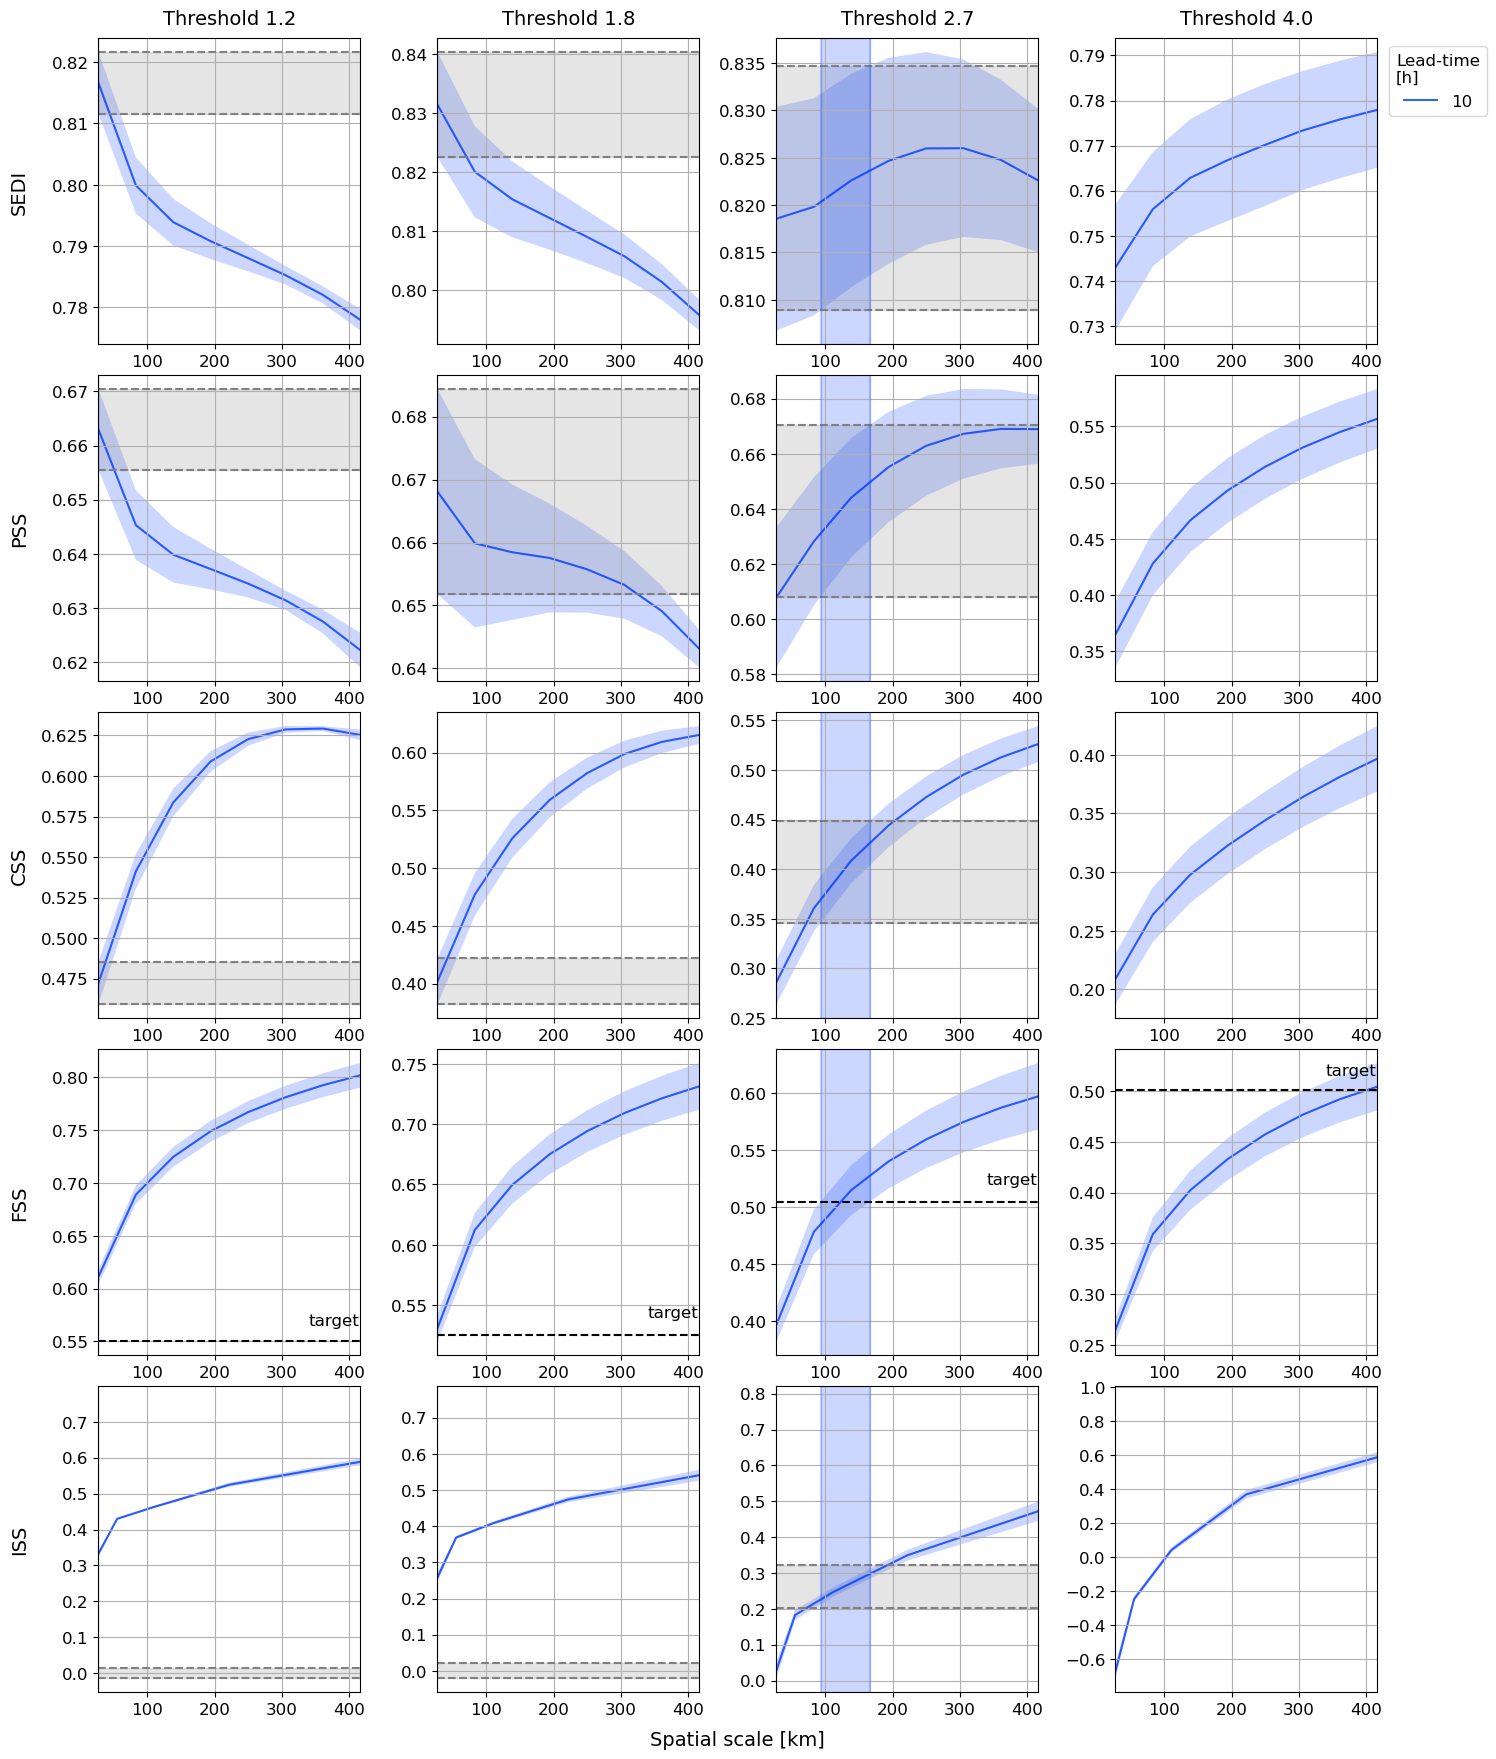

In [900]:
intercepts_top, intercepts_bot = plot_scores_scales_together(scores_times, scores_scales, stds_times, stds_scales, thresholds, args, intercepts_left, intercepts_right, random, save_as = 'big_fig_times.png')

In [901]:
def plot_scores_scales_together(scores_times, scores_scales, stds_times, stds_scales, thresholds, args, intercepts_left, intercepts_right, random, save_as=None):
    
    score_names = ['SEDI','PSS','CSS','FSS','ISS']
    alpha=0.6
    
    fig, axes = plt.subplots(figsize=(16,18),nrows=5, ncols=1, sharex=True, sharey=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Spatial scale [km]", fontsize=14,labelpad=10)
    #plt.suptitle(title,fontsize=14)
    
    for i, ax in enumerate(axes):
        #ax.set_title(score_names[i], fontsize=14)
        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        #big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        # removes the white frame
        ax._frameon = False
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticklabels([])
        ax.get_yaxis().set_ticklabels([])
        ax.set_ylabel(score_names[i],fontsize=14, labelpad=40)
    

    #col = matplotlib.cm.get_cmap('hsv_r')(np.linspace(0.5,1.,len(scales))) 
    #col = matplotlib.cm.get_cmap('jet')(np.linspace(0.3,1.,len(scales))) 
    col = matplotlib.cm.get_cmap('jet_r')(np.linspace(0.5,1.,12)) 
    count=-1
    
    def get_y_intercept(x0,x1,y0,y1,v):
        a = (y1-y0)/(x1-x0)
        b = y0 - a*x0
        return a*v+b
    
    def get_score_intercepts(scores, intercepts, thresholds, km_scales):
        scores_intercepts = np.empty((len(thresholds),scores.shape[-1]))
        scores_intercepts[:,:] = np.NaN
        for i, threshold in enumerate(thresholds):
            for j, time in enumerate(np.arange(0,scores.shape[-1],1)):  
                curve = scores[i,:,j]
                for k, x in intercepts[i]:
                    if j==k: 
                        if x==27.75: 
                            scores_intercepts[i,j] = curve[-1]
                        elif np.isnan(x):
                            continue
                        else:
                            indx = np.where(km_scales == km_scales[km_scales>=x][-1])[0][0] # index of smallest scale larger than x
                            y0 = curve[indx]#[km_scales>=x][-1]
                            y1 = curve[indx+1]#[km_scales>=x][-2]
                            x0 = km_scales[np.where(curve==y0)[0][0]]
                            x1 = km_scales[np.where(curve==y1)[0][0]]
                            y = get_y_intercept(x0,x1,y0,y1,x)
                            scores_intercepts[i,j] = y
        return scores_intercepts
    
    intercepts_top = np.zeros((5,len(thresholds),scores_times.shape[-1]))
    intercepts_bot = np.zeros((5,len(thresholds),scores_times.shape[-1]))
    
    for l, s in enumerate([0,1,2,6,7]):
        count+=1
        if s==7: 
            scales = [(64,64),(32,32),(16,16),(8,8),(4,4),(2,2),(1,1)]
            scores = (scores_times[s]+stds_times[s])[:,:-1,:]
        else: 
            scales = [(15,15),(13,13),(11,11),(9,9),(7,7),(5,5),(3,3),(1,1)]
            scores = scores_times[s]+stds_times[s]
        
        km_scales = np.array([sc[0]*111/4 for sc in scales])
        km_scales_rounded = np.array([int(np.round(sc,-1)) for sc in km_scales])
        
        
        scores_intercepts_top = get_score_intercepts(scores, intercepts_right, thresholds, km_scales) 
        scores_intercepts_bot = get_score_intercepts(scores, intercepts_left, thresholds, km_scales) 
        intercepts_top[l] = scores_intercepts_top
        intercepts_bot[l] = scores_intercepts_bot
        
        for i, threshold in enumerate(thresholds):
            
            ax = fig.add_subplot(5,4,4*count+i+1)                
                
            if i==0:
                ax0=ax
            if i!=0:
                ax.sharey(ax0)
                plt.setp(ax.get_yticklabels(), visible=False)
            if s!=7:
                ax.set_xticklabels([])
            #ax.axvline(x=8,ls='--',c='grey')
            #ax.set_ylim(-0.5,0.5)
            ax.set_xlim(27.75,416.25)
            ax.tick_params(axis='both', which='major', labelsize=12)
            #ax.set_xticks(np.arange(2,args.frames_predict+1,2))
            ax.grid(True,axis='both')
            if l==0:
                ax.set_title('Threshold %s'%threshold, fontsize=14,pad=10)
                #ax.set_ylim(-0.5,0.5)
            #for j, scale in enumerate(scales): 
            for j, time in enumerate(np.arange(0,12,1)):  
                if s==7:
                    ax.plot(km_scales, scores_times[s,i,:-1,time], label=time+1, c=col[time], alpha=alpha,zorder=1)
                    ax.fill_between(km_scales, scores_times[s,i,:-1,time]-stds_times[s,i,:-1,time], scores_times[s,i,:-1,time]+stds_times[s,i,:-1,time],alpha=0.2, facecolor=col[time],linewidth=1)                    
                                        
                else:
                    ax.plot(km_scales, scores_times[s,i,:,time], label=time+1, c=col[time], alpha=alpha,zorder=1)            
                    ax.fill_between(km_scales, scores_times[s,i,:,time]-stds_times[s,i,:,time], scores_times[s,i,:,time]+stds_times[s,i,:,time],alpha=0.2, facecolor=col[time],linewidth=1)
                            
                #ax.plot(np.arange(1, args.frames_predict+1), scores[i][j], label=km_scales_rounded[j], c=col[j], alpha=0.5)
                #error = fss_std/2
                #ax.fill_between(np.arange(1, len(fss_mean)+1), fss_mean-error, fss_mean+error,
                #    alpha=0.2, facecolor=col[j],
                #    linewidth=0)
            if s==7:
                ax.errorbar(km_scales,scores_scales[s,i,:-1],stds_scales[s,i,:-1],label='Overall',ls='-.',c='black',elinewidth=0.5, capsize=3,capthick=0.5)
            else:
                ax.errorbar(km_scales,scores_scales[s,i],stds_scales[s,i],label='Overall',ls='-.',c='black',elinewidth=0.5, capsize=3,capthick=0.5)
                
            if l==0 and i==3:
                legend=ax.legend(loc='upper right',title="Lead-time [h]",fontsize=12,bbox_to_anchor=(1.55, 1.0))  
                legend.get_title().set_fontsize('12') #legend 'Title' fontsize

    #         if plot_random: 
    #             if len(intercepts[i])!=0: 
    #                 for j, x in intercepts[i]: 
    #                     ax.axvline(x=x,ls='--',c=col[j],ymax=(1+comparative_lines[i])/2,alpha=alpha)
    
            
        
        axes[1].get_shared_x_axes().join(axes[2], axes[3],axes[4],axes[1])
        
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    plt.savefig(data_root + save_as)
    plt.show()

    return intercepts_top, intercepts_bot 

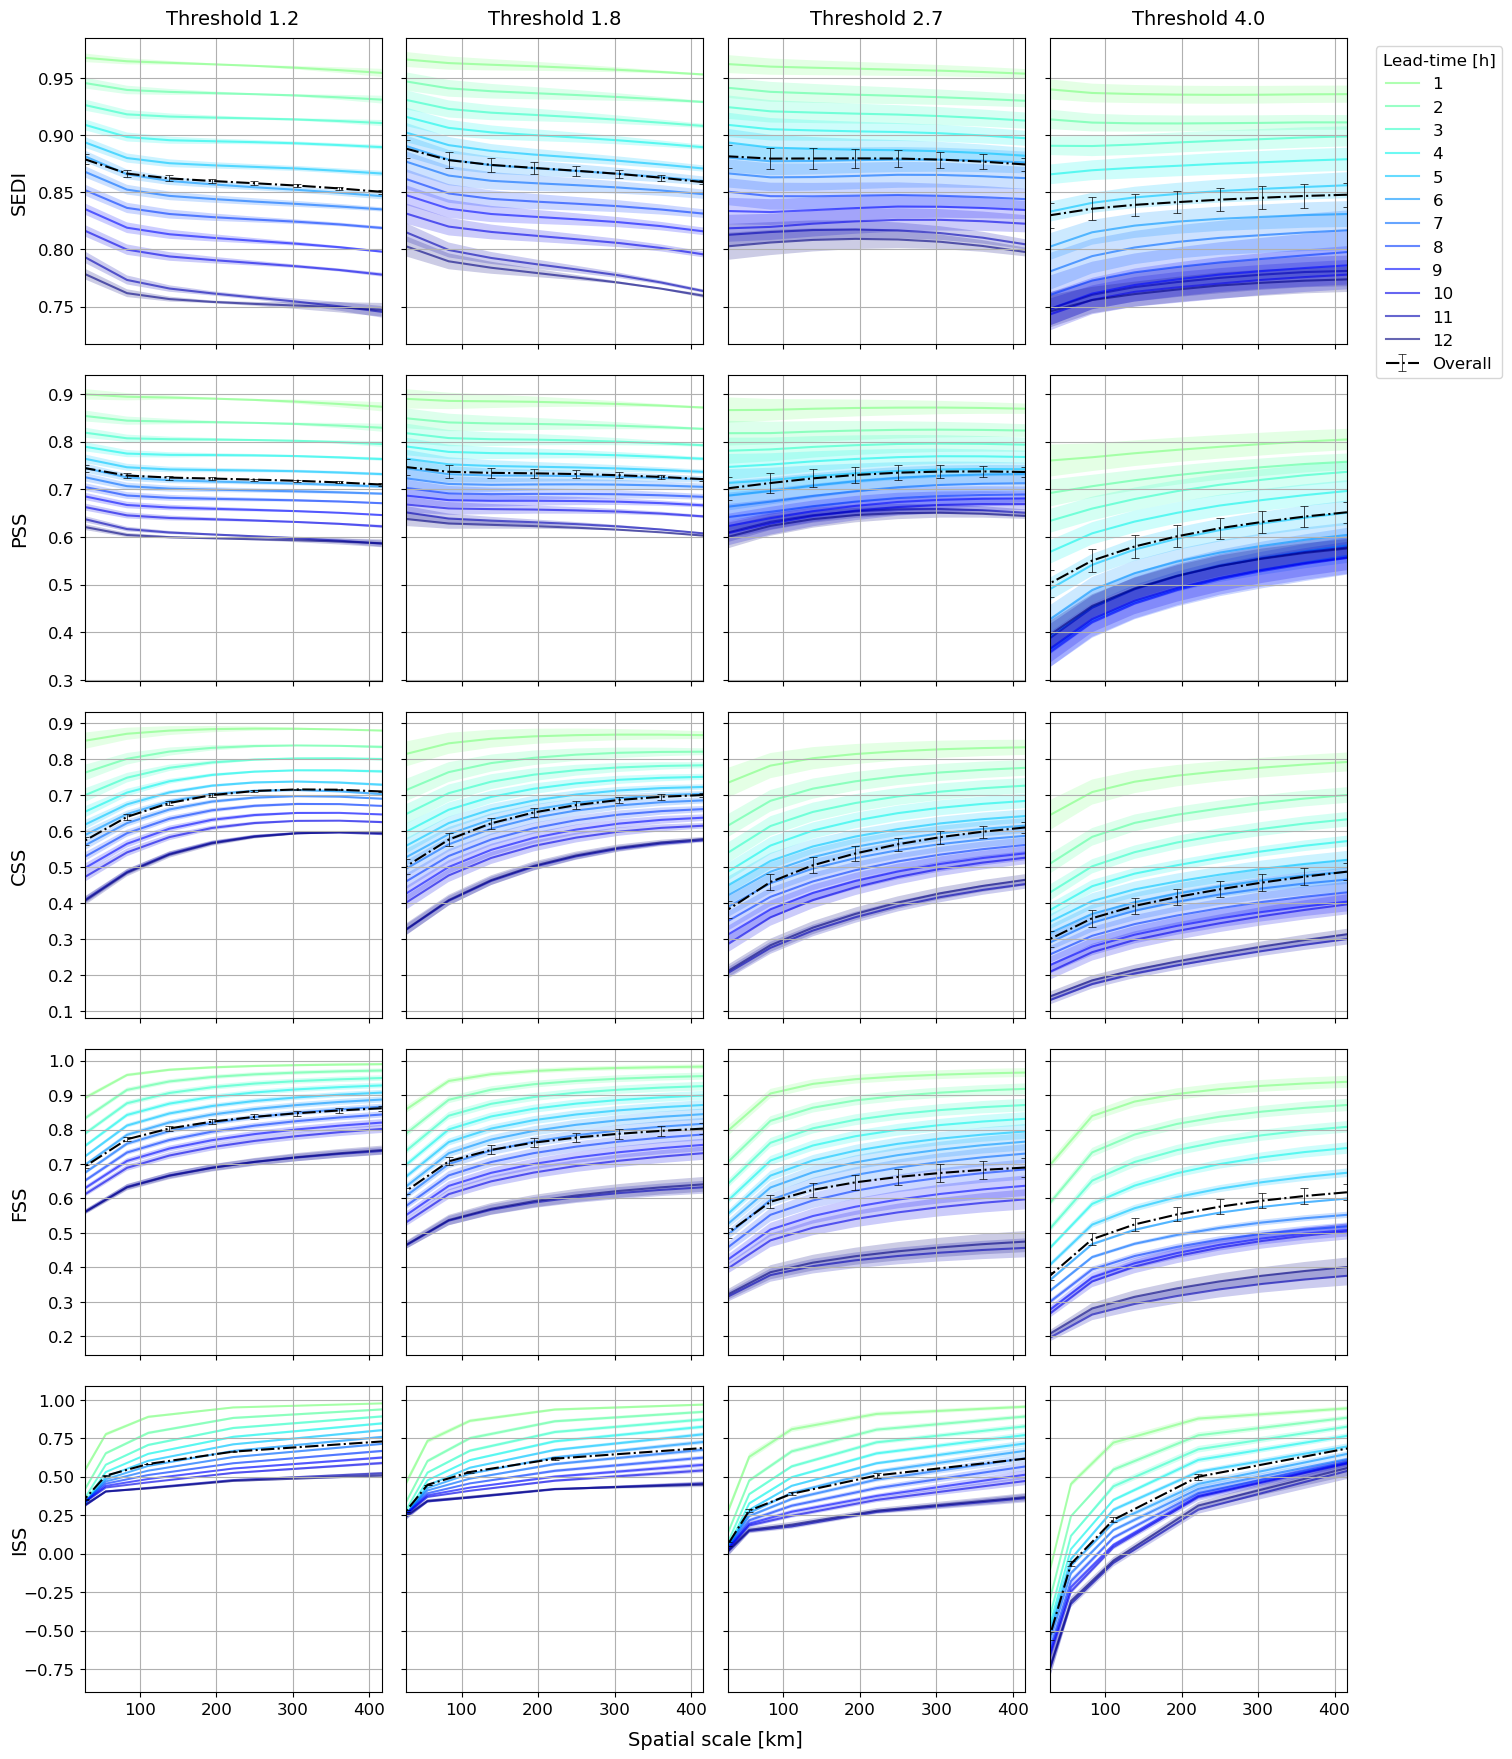

In [902]:
intercepts_top, intercepts_bot = plot_scores_scales_together(scores_times, scores_scales, stds_times, stds_scales, thresholds, args, intercepts_left, intercepts_right, random, save_as = 'big_fig_times.png')

In [905]:
scores_intercepts = (intercepts_top+intercepts_bot)/2
scores_stds = scores_intercepts-intercepts_bot 

In [955]:
scores_intercepts.shape

(5, 4, 12)

In [948]:
scales_intercepts = [[(intercepts_left[i][t][1]+intercepts_right[i][t][1])/2 for t in range(12)] for i in range(4)]
scales_stds = [[(scales_intercepts[i][t]-intercepts_left[i][t][1]) for t in range(12)] for i in range(4)]

In [939]:
t = 3
for i in range(12):
    print(np.round((intercepts_right[t][i][1]+intercepts_left[t][i][1])/2,0), np.round((intercepts_right[t][i][1]+intercepts_left[t][i][1])/2 - intercepts_left[t][i][1],0))

28.0 0.0
28.0 0.0
28.0 0.0
47.0 3.0
72.0 4.0
127.0 5.0
213.0 18.0
327.0 44.0
nan nan
nan nan
nan nan
nan nan


In [985]:
t=0
s=1
for i in range(12):
    print(np.round(scores_intercepts[s][t][i],3), np.round(stds_intercepts[s][t][i],3))
    #print(scores_intercepts[s][t][i], intercepts_bot[s][t][i], intercepts_top[s][t][i])

0.911 0.0
0.866 0.0
0.83 0.0
0.799 0.0
0.774 0.0
0.755 0.0
0.735 0.0
0.713 0.0
0.693 0.0
0.67 0.0
0.644 0.0
0.627 0.0


In [991]:
scores_times[7,0,-2,-1], stds_times[7,0,-2,-1]

(0.31402510430562736, 0.015006304368167972)

In [992]:
def plot_heatmaps_final(intercepts, all_scores_intercepts, save_as):
    fig, axes = plt.subplots(figsize=(8,14))
    axes._frameon = False
    #axes.get_xaxis().set_visible(False)
    #axes.get_yaxis().set_visible(False)
    axes.get_xaxis().set_ticks([])
    axes.get_yaxis().set_ticks([])
    axes.get_xaxis().set_ticklabels([])
    axes.get_yaxis().set_ticklabels([])
    
    plt.xlabel(r"Lead-time [h]"
                          "\n"
                          "&"
                          "\n"
                          "Minimum spatial scale for sufficient skill [km]", fontsize=14, labelpad=50)

    for i, threshold in enumerate(thresholds):

        df = pd.DataFrame(data = np.round(all_scores_intercepts[:,i],2),
                          index=['SEDI','PSS','CSS','FSS','ISS'],
                          columns=np.arange(1,13,1))

        ax = fig.add_subplot(4,1,i+1)
        ax._frameon = True
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)
        sbh = sb.heatmap(df, annot=True, fmt=".2f", cmap='RdYlGn' ,
                           vmin=0, vmax=1, cbar=False)#, cbar_kws={"shrink": .8, "ticks":[0,1]})
        #cbar = ax.collections[0].colorbar
        sbh.set_yticklabels(sbh.get_yticklabels(), rotation = 0)
        ax.set_title('Threshold %s'%threshold, fontsize=12, pad=10)
#         if i==3:
#             ax.set_xlabel(r"Lead-time [h]"
#                           "\n"
#                           "&"
#                           "\n"
#                           "Minimum spatial scale for sufficient skill [km]", fontsize=12, labelpad=30)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        for j in range(len(intercepts[i])):
            if not np.isnan(intercepts[i][j]):
                if intercepts[i][j]>=100: 
                    ax.text(x=0.35+j*0.995,y=5.9,s=int(np.round(intercepts[i][j],-1)))
                else: 
                    ax.text(x=0.35+j*0.995,y=5.9,s=int(np.round(intercepts[i][j],0)))
    
    
   
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.4)
    plt.savefig(data_root + save_as)
    plt.show()
    return 

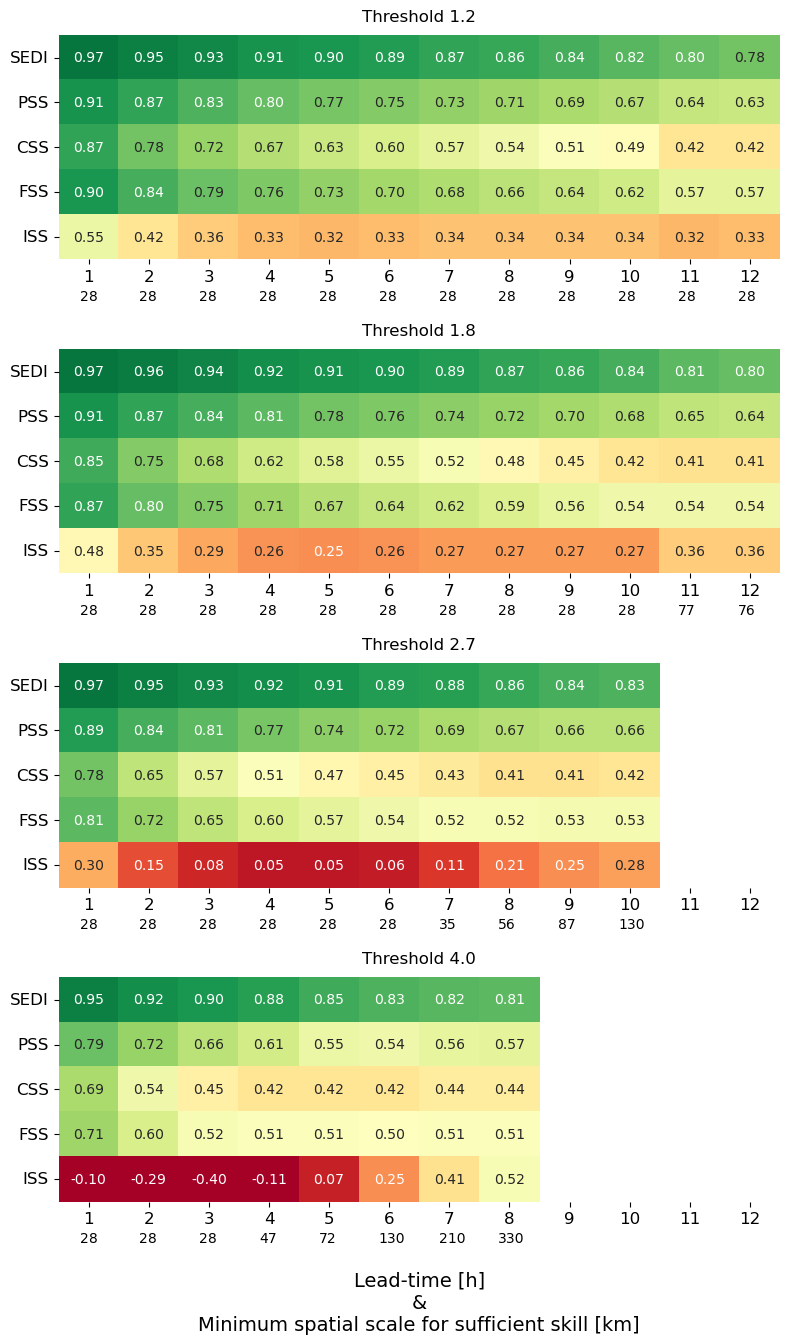

In [993]:
plot_heatmaps_final(scales_intercepts, scores_intercepts, 'heatmaps_final.png')

In [377]:
all_scores_intercepts_persist = plot_scores_scales_together([(MC_T-MC_T_persist)/(1-MC_T_persist), (IS_T[i]-IS_T_persist)/(1-IS_T_persist)], 
                                                    [(MC_S-MC_S_persist)/(1-MC_S_persist), (IS_S[i]-IS_S_persist)/(1-IS_S_persist)], 
                                                    thresholds, 
                                                    args, 
                                                    intercepts=intercepts, 
                                                    save_as = 'big_fig_times_persist.png')

IndexError: index 4 is out of bounds for axis 0 with size 4

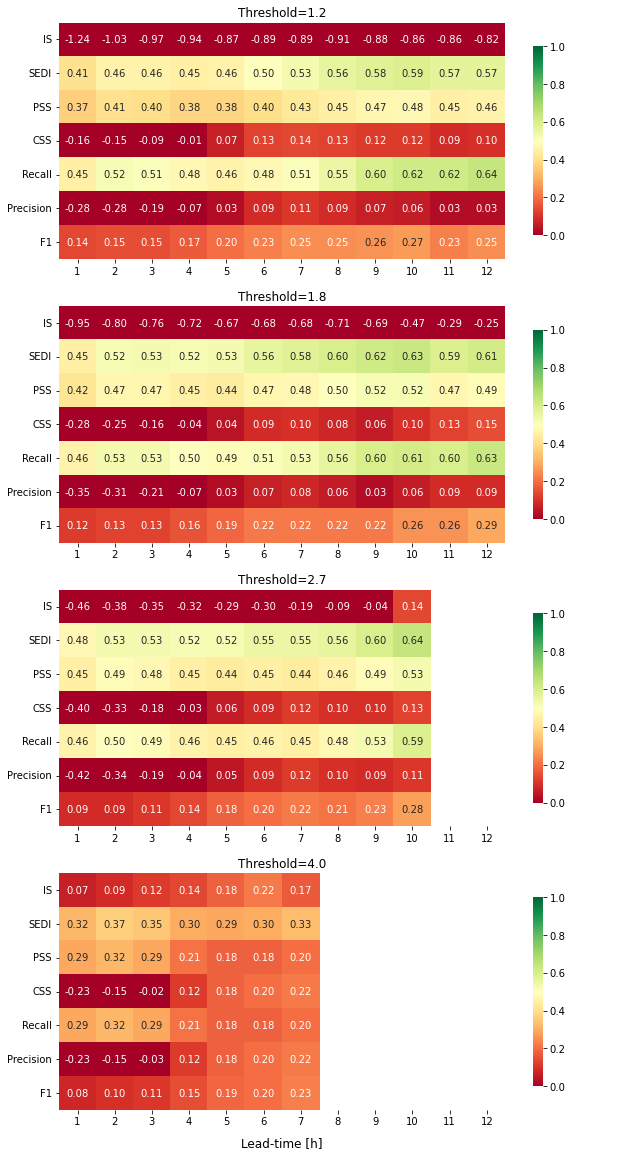

In [282]:
plot_heatmaps_final(all_scores_intercepts_persist, 'heatmaps_final_persist.png')